## Core Idea of the Method

The method works in **two main phases**:

### Phase I: Spatial Zoning (SOM)
- Use a **Self-Organizing Map (SOM)** to group earthquakes based on **location and depth**.  
- This divides the seismic region into smaller, distinct **zones or hotspots**.  
- The SOM essentially learns the **geography of seismicity**.  

### Phase II: Temporal Clustering (T-DBSCAN)
- For each spatial zone, analyze events **independently**.  
- Apply **DBSCAN** using only the **time of occurrence** of events.  
- This helps identify:
  - **Rapid bursts of activity** (aftershock sequences).  
  - **Steady, random background seismicity** (declustered events).  


In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from datetime import datetime

In [3]:
data=pd.read_csv("../../data/processed/data.csv")
df=data.copy()
df

,date,time,latitude,longitude,depth,magnitude
0,1980-01-01,07:04:05.60,-41.287000,175.235000,26.100000,2.567000
1,1980-01-01,09:27:04.52,-40.490000,174.669010,72.600000,3.200000
2,1980-01-01,18:28:10.99,-37.630000,176.380000,210.000000,4.150000
3,1980-01-01,20:20:54.03,-40.290000,173.429990,212.000000,4.500000
4,1980-01-02,18:24:15.40,-38.480000,176.750000,5.000000,3.375000
...,...,...,...,...,...,...
396266,2024-12-31,18:31:44.72,-45.076202,167.357101,74.645035,2.920129
396267,2024-12-31,20:37:56.20,-37.985142,176.407059,133.171555,2.605564
396268,2024-12-31,21:24:08.59,-38.524281,175.719986,157.843369,2.570573
396269,2024-12-31,23:26:03.90,-38.329933,178.956192,12.000000,2.406177


In [4]:
print("Processing the data\n")

N=len(df)
N

Processing the data



396271

In [5]:
df.columns

Index(['date', 'time', 'latitude', 'longitude', 'depth', 'magnitude'], dtype='object')

In [6]:
# Combine date and time into a single datetime (optional but useful downstream)
def parse_dt(row):
    ds = str(row['date']).strip()
    ts = str(row['time']).strip()
    # Try common formats; customize if your file uses a different format
    for dfmt in ['%Y-%m-%d', '%d-%m-%Y', '%Y/%m/%d', '%d/%m/%Y']:
        for tfmt in ['%H:%M:%S', '%H:%M', '%H%M%S', '%H%M']:
            try:
                return datetime.strptime(ds + ' ' + ts, dfmt + ' ' + tfmt)
            except Exception:
                pass
    # Fallback: try pandas
    try:
        return pd.to_datetime(ds + ' ' + ts, errors='coerce')
    except Exception:
        return pd.NaT

if 'date' in df.columns and 'time' in df.columns:
    df['datetime'] = df.apply(parse_dt, axis=1)
else:
    df['datetime'] = pd.NaT

# Basic cleaning
df = df.dropna(subset=['latitude', 'longitude', 'depth']).reset_index(drop=True)

# Build input vectors X = [lon_rad, lat_rad, depth_km]
lat_rad = np.deg2rad(df['latitude'].values.astype(float))
lon_rad = np.deg2rad(df['longitude'].values.astype(float))
depth_km = df['depth'].values.astype(float)
X = np.stack([lon_rad, lat_rad, depth_km], axis=1)


In [9]:
X

array([[  3.05842771,  -0.72059409,  26.1       ],
       [  3.04854933,  -0.70668381,  72.6       ],
       [  3.07841173,  -0.6567674 , 210.        ],
       ...,
       [  3.06689232,  -0.67237554, 157.84336853],
       [  3.12337477,  -0.66898354,  12.        ],
       [  3.02714384,  -0.73100696,  51.37464523]], shape=(396271, 3))

## Distance measure

In [ ]:

# ----------------------------
# Step 3: Spatial distance n_ij
# ----------------------------
RE_KM = 6371.0  # Earth radius in km

def great_circle_distance_rad(lon1, lat1, lon2, lat2, R=RE_KM):
    """
    Great-circle distance on a sphere using the inverse spherical cosine formula.
    All angles in radians; returns distance in km.
    """
    # Compute cosine of central angle
    cos_gamma = np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon2 - lon1)
    # Clamp numerical noise
    cos_gamma = np.clip(cos_gamma, -1.0, 1.0)
    return R * np.arccos(cos_gamma)

def g_distance_point_to_point(x, y):
    """
    Full spatial metric g(x,y) = sqrt( R^2 + (dz)^2 ) where
    R is great-circle distance and dz is depth difference (km).
    x, y are arrays like [lon_rad, lat_rad, depth_km].
    """
    R = great_circle_distance_rad(x, x[1], y, y[1], R=RE_KM)
    dz = (y - x)
    return np.sqrt(R * R + dz * dz)

def g_distance_point_to_many(x, W):
    """
    Vectorized g-distance from one point x to all prototypes in W.
    x shape (3,), W shape (M,3). Returns distances shape (M,).
    """
    # Unpack
    lon1, lat1, z1 = x
    lon2 = W[:, 0]
    lat2 = W[:, 1]
    z2 = W[:, 2]
    # Great-circle component
    cos_gamma = np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon2 - lon1)
    cos_gamma = np.clip(cos_gamma, -1.0, 1.0)
    R = RE_KM * np.arccos(cos_gamma)
    dz = (z2 - z1)
    return np.sqrt(R * R + dz * dz)

In [11]:
# ----------------------------
# Step 4: SOM implementation
# ----------------------------
class SOM:
    def __init__(self, grid=(6, 6), iterations=100, a0=0.1, aT=0.01, r0=None, rT=1.0, seed=42):
        """
        2D lattice SOM with Gaussian neighborhood and linear decays.
        grid: (gx, gy) neurons
        iterations: training epochs
        a0, aT: initial and final learning rates
        r0, rT: initial and final neighborhood radii (in grid units); if r0 None, set to max(grid)/2
        """
        self.gx, self.gy = grid
        self.m = self.gx * self.gy
        self.iterations = iterations
        self.a0 = a0
        self.aT = aT
        self.r0 = r0 if r0 is not None else max(self.gx, self.gy) / 2.0
        self.rT = rT
        self.seed = seed
        self.W = None       # weights (m, 3): [lon_rad, lat_rad, depth_km]
        self.grid_xy = None # grid coordinates (m, 2)
        self.qe_curve = []  # quantization error per epoch
        self.hits = None    # hit counts per neuron

    def _init_weights(self, X):
        rng = np.random.default_rng(self.seed)
        # Initialize weights by sampling from data for realistic starting positions
        idx = rng.integers(0, X.shape, size=self.m)
        self.W = X[idx].copy()

        # Build grid coordinates for neighborhood function (rectangular lattice)
        gx, gy = self.gx, self.gy
        grid = []
        for iy in range(gy):
            for ix in range(gx):
                grid.append([ix, iy])
        self.grid_xy = np.array(grid, dtype=float)

    def _bmu_index(self, x):
        # BMU index under custom g-distance
        d = g_distance_point_to_many(x, self.W)
        return int(np.argmin(d))

    def _gaussian_neighborhood(self, c, r_t):
        # Compute Gaussian neighborhood h_{c,l} over grid coordinates
        rc = self.grid_xy[c]
        d2 = np.sum((self.grid_xy - rc) ** 2, axis=1)
        if r_t <= 0:
            h = np.zeros_like(d2)
            h[c] = 1.0
            return h
        return np.exp(-d2 / (2.0 * (r_t ** 2)))

    def _quantization_error(self, X):
        # Mean g-distance from each sample to its BMU prototype
        total = 0.0
        for x in X:
            c = self._bmu_index(x)
            total += g_distance_point_to_point(x, self.W[c])
        return total / X.shape

    def fit(self, X):
        self._init_weights(X)
        n = X.shape
        rng = np.random.default_rng(self.seed)

        for t in range(self.iterations):
            # Linear decays
            a_t = self.a0 + (self.aT - self.a0) * (t / max(1, self.iterations - 1))
            r_t = self.r0 + (self.rT - self.r0) * (t / max(1, self.iterations - 1))

            # Shuffle indices
            order = rng.permutation(n)

            for idx in order:
                x = X[idx]
                c = self._bmu_index(x)
                h = self._gaussian_neighborhood(c, r_t)  # (m,)
                # Update all prototypes
                self.W += (a_t * h)[:, None] * (x - self.W)

            # Track quantization error
            qe = self._quantization_error(X)
            self.qe_curve.append(qe)
            # Optional: print progress
            # print(f"Epoch {t+1}/{self.iterations} - QE: {qe:.4f}")

        # Compute hits
        hits = np.zeros(self.m, dtype=int)
        bmu_idx = []
        for i in range(n):
            c = self._bmu_index(X[i])
            hits[c] += 1
            bmu_idx.append(c)
        self.hits = hits
        return np.array(bmu_idx, dtype=int)

# ----------------------------
# Train SOM (Step 4) and save outputs
# ----------------------------
# Hyperparameters (adjust as needed or per region)
grid = (6, 6)          # choose based on event density (paper examples use ~5x5 to 7x7)
iterations = 100       # as in the study
a0, aT = 0.1, 0.01     # learning rate decay
r0, rT = max(grid), 1  # neighborhood radius decay (grid units)

som = SOM(grid=grid, iterations=iterations, a0=a0, aT=aT, r0=r0, rT=rT, seed=42)
bmu_assignments = som.fit(X)

# Prototypes (convert lon/lat back to degrees for readability)
lon_deg_W = np.rad2deg(som.W[:, 0])
lat_deg_W = np.rad2deg(som.W[:, 1])
depth_W = som.W[:, 2]
gx, gy = som.gx, som.gy

# Build prototype dataframe with grid positions
grid_positions = som.grid_xy.astype(int)
proto_df = pd.DataFrame({
    'neuron_id': np.arange(som.m, dtype=int),
    'grid_x': grid_positions[:, 0],
    'grid_y': grid_positions[:, 1],
    'lon_deg': lon_deg_W,
    'lat_deg': lat_deg_W,
    'depth_km': depth_W,
    'hits': som.hits
})
proto_df.to_csv('som_prototypes.csv', index=False)

# Assignments per event
assign_df = pd.DataFrame({
    'event_index': np.arange(df.shape, dtype=int),
    'datetime': df['datetime'].astype(str),
    'latitude': df['latitude'].values,
    'longitude': df['longitude'].values,
    'depth_km': df['depth'].values,
    'magnitude': df['magnitude'].values if 'magnitude' in df.columns else np.nan,
    'bmu_id': bmu_assignments
})
assign_df.to_csv('som_assignments.csv', index=False)

# Quantization error curve
qe_df = pd.DataFrame({
    'epoch': np.arange(1, len(som.qe_curve) + 1, dtype=int),
    'quantization_error_g': som.qe_curve
})
qe_df.to_csv('som_qe.csv', index=False)

print("Saved: som_prototypes.csv, som_assignments.csv, som_qe.csv")

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 1 with shape (2,) and arg 2 with shape (36,).

In [13]:
#!/usr/bin/env python3
"""
Self-Organizing Map (SOM) for earthquake catalog declustering (Phase I of SOM–DBSCAN)

- Reads data.csv with columns: ['date','time','latitude','longitude','depth','magnitude']
- Uses [lat(rad), lon(rad), depth(km)] as features
- Distance metric = great-circle + depth separation (Eq. 9–10 in paper)
- Trains SOM for candidate grid sizes (5x5, 6x6, 7x7), 100 iterations each
- Selects best grid by minimizing quantization error (QE)
- Saves:
    som_prototypes.csv  → neuron coordinates (lat, lon, depth)
    som_assignments.csv → input catalog with BMU zone assignments
    som_hits_map.png    → heatmap of neurons hit counts
    som_prototypes_map.png → spatial map of prototypes and events
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# ----------------------------
# Parameters (you can tweak)
# ----------------------------
GRID_CANDIDATES = [(5,5), (6,6), (7,7)]   # candidate grid sizes
ITERATIONS = 100                          # training iterations
RE = 6371.0                               # Earth radius (km)
INITIAL_LEARNING_RATE = 0.1
FINAL_LEARNING_RATE = 0.01
INITIAL_RADIUS = None                     # if None → max(nx,ny)/2
FINAL_RADIUS = 1.0
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ----------------------------
# Helper functions
# ----------------------------
def read_catalog(fname="data.csv"):
    df = pd.read_csv(fname)
    # parse datetime
    dt = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str), errors='coerce')
    df['datetime'] = dt
    df = df.dropna(subset=['datetime','latitude','longitude','depth']).copy()
    df = df.sort_values('datetime').reset_index(drop=True)
    # time in days since first event (for DBSCAN later)
    t0 = df['datetime'].iloc[0]
    df['time_days'] = (df['datetime'] - t0).dt.total_seconds() / (3600*24)
    return df

def great_circle_distance_km(lat1, lon1, lat2, lon2):
    arg = np.sin(lat1)*np.sin(lat2) + np.cos(lat1)*np.cos(lat2)*np.cos(lon2 - lon1)
    arg = np.clip(arg, -1.0, 1.0)
    return RE * np.arccos(arg)

def batch_spatial_depth_distance_vec(x, weights):
    lat1 = x[0]; lon1 = x[1]
    lat2 = weights[:,0]; lon2 = weights[:,1]
    arg = np.sin(lat1)*np.sin(lat2) + np.cos(lat1)*np.cos(lat2)*np.cos(lon2 - lon1)
    arg = np.clip(arg, -1.0, 1.0)
    Rij = RE * np.arccos(arg)
    dd = weights[:,2] - x[2]
    return np.sqrt(Rij**2 + dd**2)

def linear_decay(initial, final, t, T):
    return initial * ((final/initial) ** (t / T))

# ----------------------------
# SOM class
# ----------------------------
class SOM:
    def __init__(self, nx, ny, data_xyz, iterations=100, a0=0.1, aT=0.01, r0=None, rT=1.0):
        self.nx, self.ny = nx, ny
        self.iterations = iterations
        self.data = data_xyz
        self.N = data_xyz.shape[0]
        self.num_neurons = nx*ny
        self.a0, self.aT = a0, aT
        self.r0 = r0 if r0 is not None else max(nx, ny)/2.0
        self.rT = rT
        self.coords = np.array([(i,j) for i in range(nx) for j in range(ny)])
        # init weights: random samples from data
        idx = np.random.choice(self.N, size=self.num_neurons, replace=True)
        self.weights = self.data[idx,:].astype(float)
        self.hits = np.zeros(self.num_neurons, dtype=int)

    def bmu_index(self, x):
        dists = batch_spatial_depth_distance_vec(x, self.weights)
        return int(np.argmin(dists)), float(np.min(dists))

    def train(self):
        T = self.iterations
        for t in range(T):
            a_t = linear_decay(self.a0, self.aT, t, T)
            r_t = linear_decay(self.r0, self.rT, t, T)
            i = np.random.randint(0, self.N)
            x = self.data[i,:]
            bmu_idx,_ = self.bmu_index(x)
            grid_dist_sq = np.sum((self.coords - self.coords[bmu_idx])**2, axis=1)
            h = np.exp(-grid_dist_sq / (2*(r_t**2)))
            factor = (a_t*h).reshape(-1,1)
            self.weights += factor*(x.reshape(1,3) - self.weights)
        # hits
        self.hits[:] = 0
        for k in range(self.N):
            bmu_idx,_ = self.bmu_index(self.data[k,:])
            self.hits[bmu_idx] += 1

    def quantization_error(self):
        total = 0.0
        for k in range(self.N):
            _,d = self.bmu_index(self.data[k,:])
            total += d
        return total/self.N

    def bmu_assignments(self):
        bmus = np.zeros(self.N, dtype=int)
        dists = np.zeros(self.N, dtype=float)
        for k in range(self.N):
            idx,d = self.bmu_index(self.data[k,:])
            bmus[k] = idx; dists[k] = d
        return bmus,dists

# ----------------------------
# Pipeline
# ----------------------------
def run_som_pipeline(datafile="data.csv"):
    df = read_catalog(datafile)
    lat_rad = np.radians(df['latitude'].values.astype(float))
    lon_rad = np.radians(df['longitude'].values.astype(float))
    depth_km = df['depth'].values.astype(float)
    data_xyz = np.vstack([lat_rad, lon_rad, depth_km]).T

    results = []
    for (nx,ny) in GRID_CANDIDATES:
        som = SOM(nx,ny,data_xyz,iterations=ITERATIONS,
                  a0=INITIAL_LEARNING_RATE,aT=FINAL_LEARNING_RATE,
                  r0=INITIAL_RADIUS,rT=FINAL_RADIUS)
        som.train()
        qe = som.quantization_error()
        print(f"Grid {nx}x{ny} QE = {qe:.4f}")
        results.append({'grid':(nx,ny),'qe':qe,'som':som})

    best = min(results,key=lambda x:x['qe'])
    best_som = best['som']; best_grid = best['grid']
    print(f"Best SOM grid: {best_grid}, QE={best['qe']:.4f}")

    # assignments
    bmus,dists = best_som.bmu_assignments()
    df['bmu'] = bmus
    df['bmu_dist_km'] = dists

    # save prototypes
    prot = best_som.weights.copy()
    prot_deg = prot.copy()
    prot_deg[:,0] = np.degrees(prot_deg[:,0])
    prot_deg[:,1] = np.degrees(prot_deg[:,1])
    prot_df = pd.DataFrame(prot_deg,columns=['lat_deg','lon_deg','depth_km'])
    prot_df['neuron_idx'] = np.arange(prot_df.shape[0])
    prot_df.to_csv("som_prototypes.csv",index=False)
    df.to_csv("som_assignments.csv",index=False)

    # hits map
    hits = best_som.hits.reshape(best_grid)
    plt.imshow(hits.T,origin='lower')
    plt.title(f"SOM hits map {best_grid}")
    plt.colorbar(label="Hits")
    plt.savefig("som_hits_map.png",dpi=150)
    plt.close()

    # prototype map
    plt.scatter(df['longitude'],df['latitude'],s=2,alpha=0.5)
    plt.scatter(prot_df['lon_deg'],prot_df['lat_deg'],s=60,marker='o')
    plt.title("Epicenters (small) and SOM prototypes (big)")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.savefig("som_prototypes_map.png",dpi=150)
    plt.close()

    print("Saved: som_prototypes.csv, som_assignments.csv, som_hits_map.png, som_prototypes_map.png")

if __name__=="__main__":
    run_som_pipeline("../../data/processed/data.csv")


Grid 5x5 QE = 365.0965
Grid 6x6 QE = 265.1151
Grid 7x7 QE = 136.9174
Best SOM grid: (7, 7), QE=136.9174
Saved: som_prototypes.csv, som_assignments.csv, som_hits_map.png, som_prototypes_map.png


Starting complete earthquake clustering analysis...
Loading earthquake data...
Loaded 396271 earthquake events
Date range: 1980-01-01 07:04:05.600000 to 2024-12-31 23:45:43.410000
Magnitude range: 2.2 to 7.8


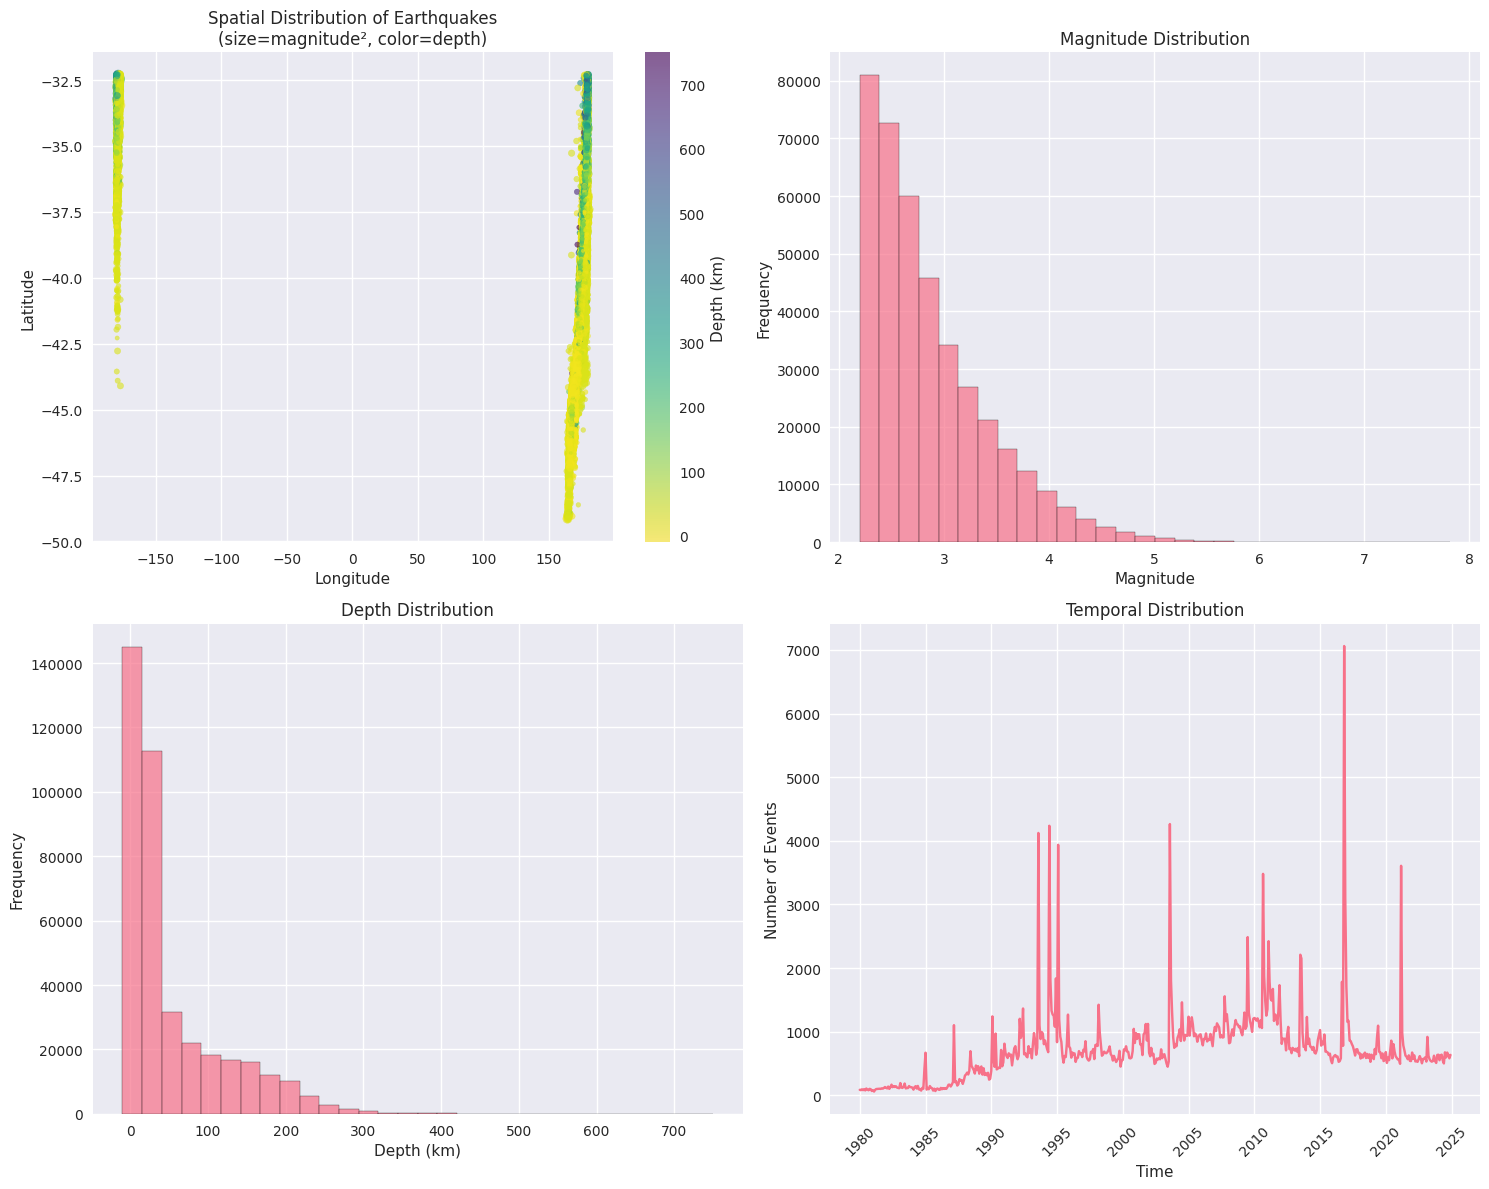

Training SOM with grid size (6, 6)...
Iteration 20/100, QE: 0.3336
Iteration 40/100, QE: 0.2546
Iteration 60/100, QE: 0.2506
Iteration 80/100, QE: 0.2117
Iteration 100/100, QE: 0.2084


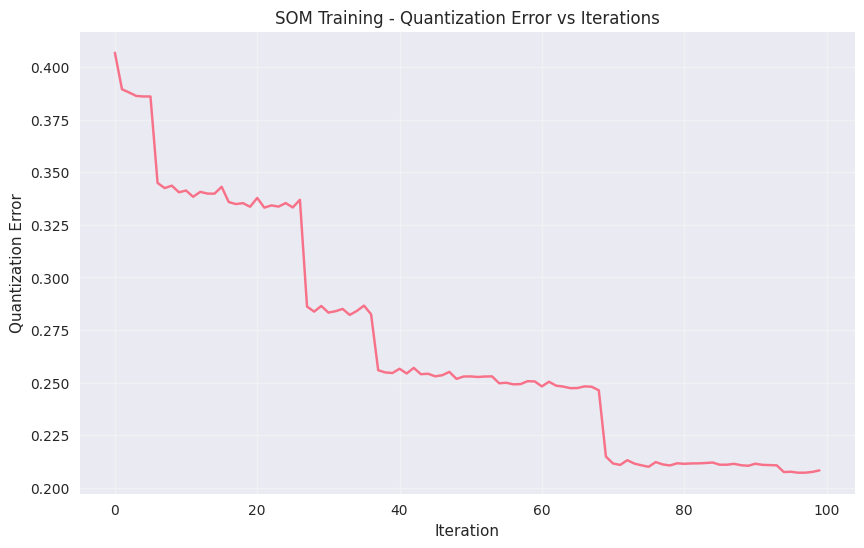

Assigning earthquakes to SOM nodes...


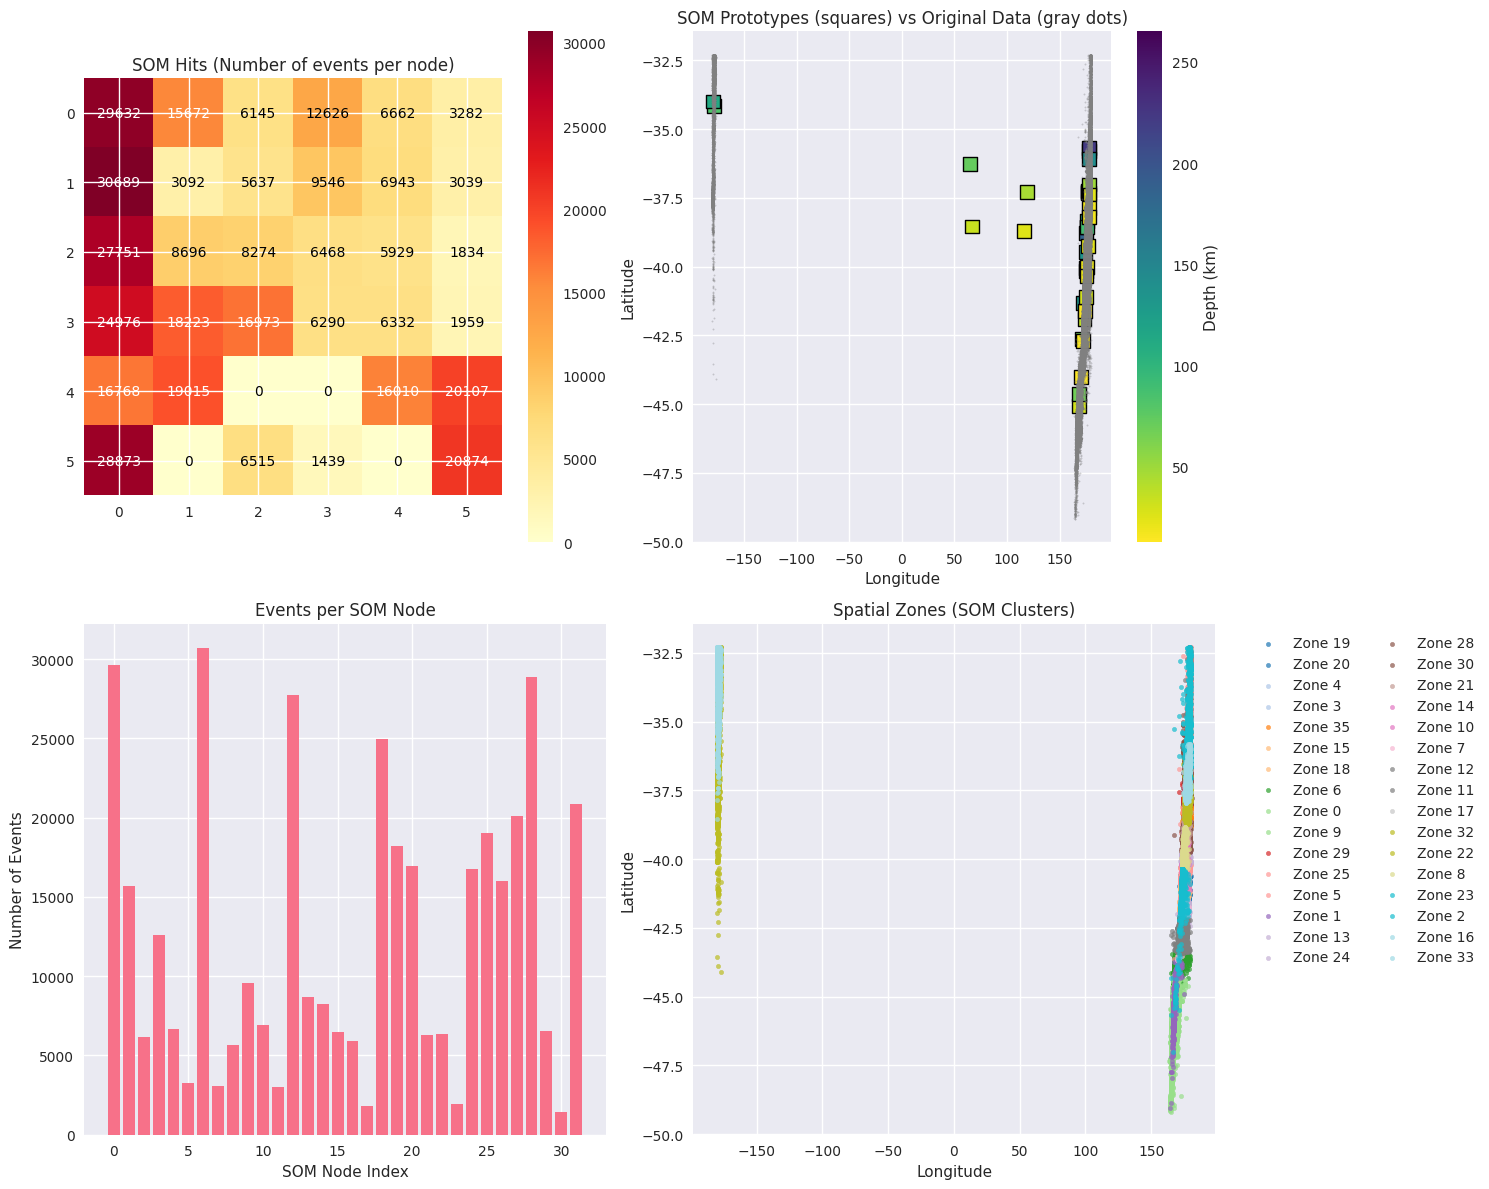

Applying temporal DBSCAN clustering...
Total events: 396271
Aftershocks: 285374 (72.0%)
Background: 110897 (28.0%)
Number of clusters: 33731


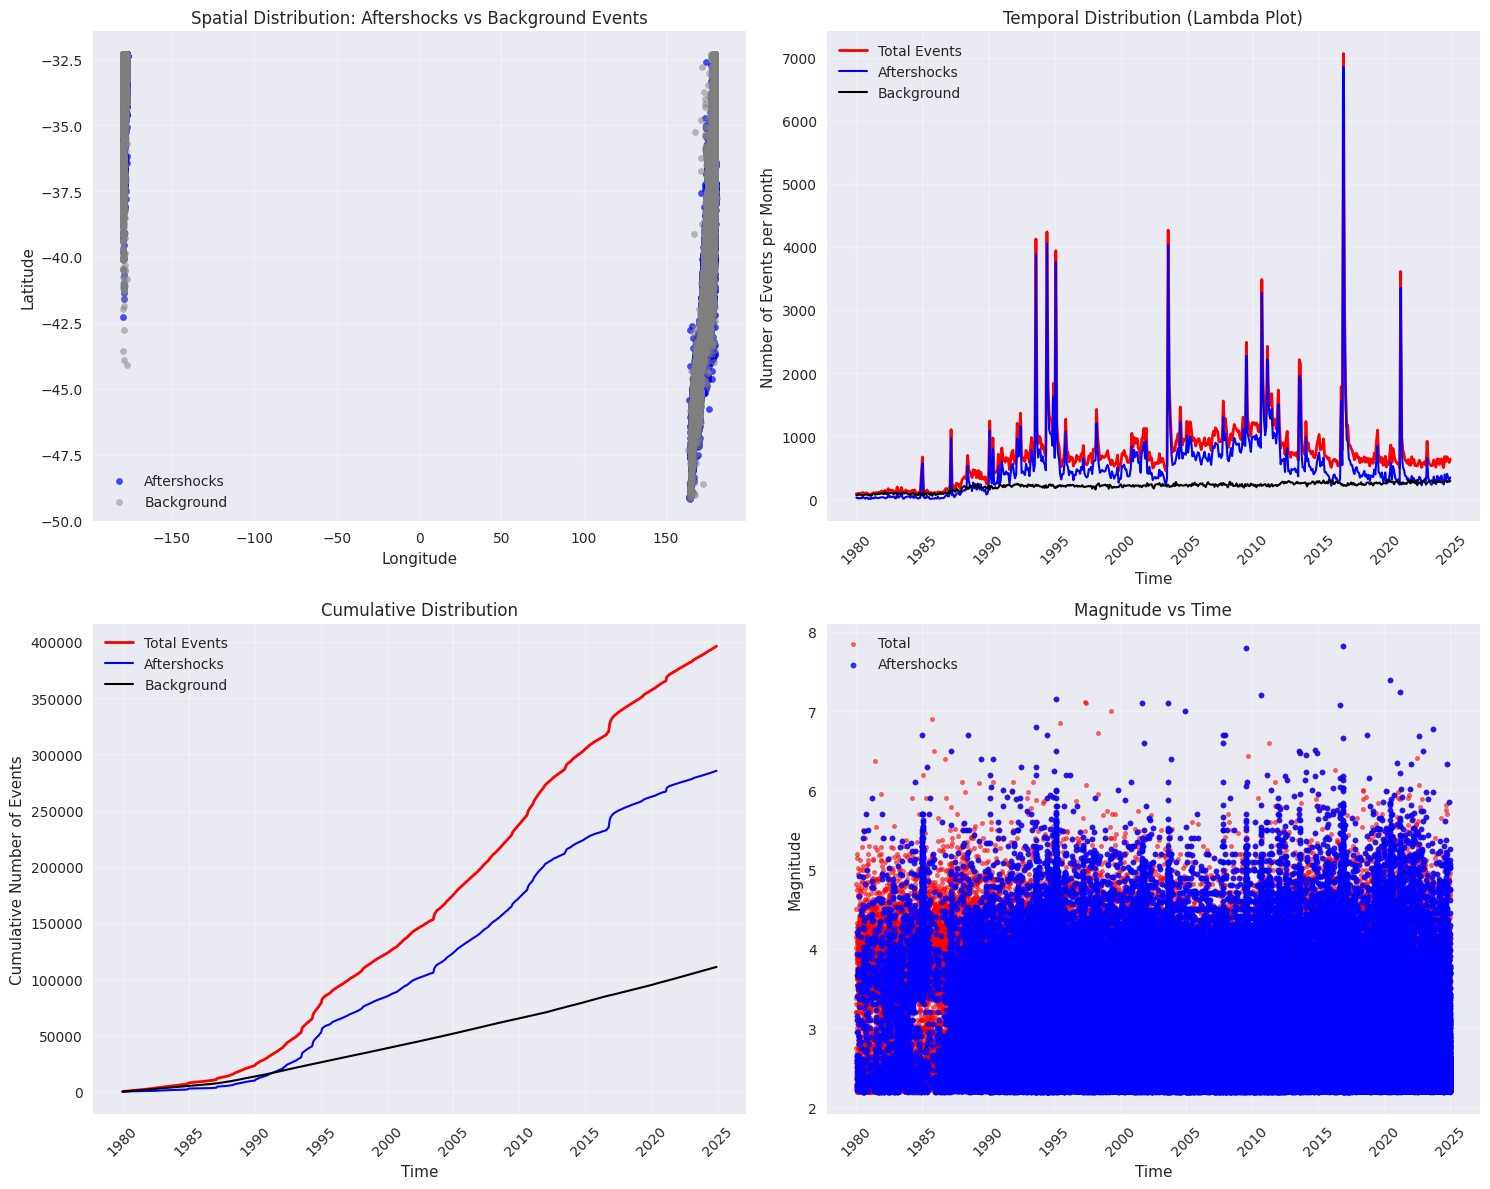

Calculating Coefficient of Variation...
COV Total: 1.8147
COV Aftershocks: 4.9918
COV Background: 1.1671


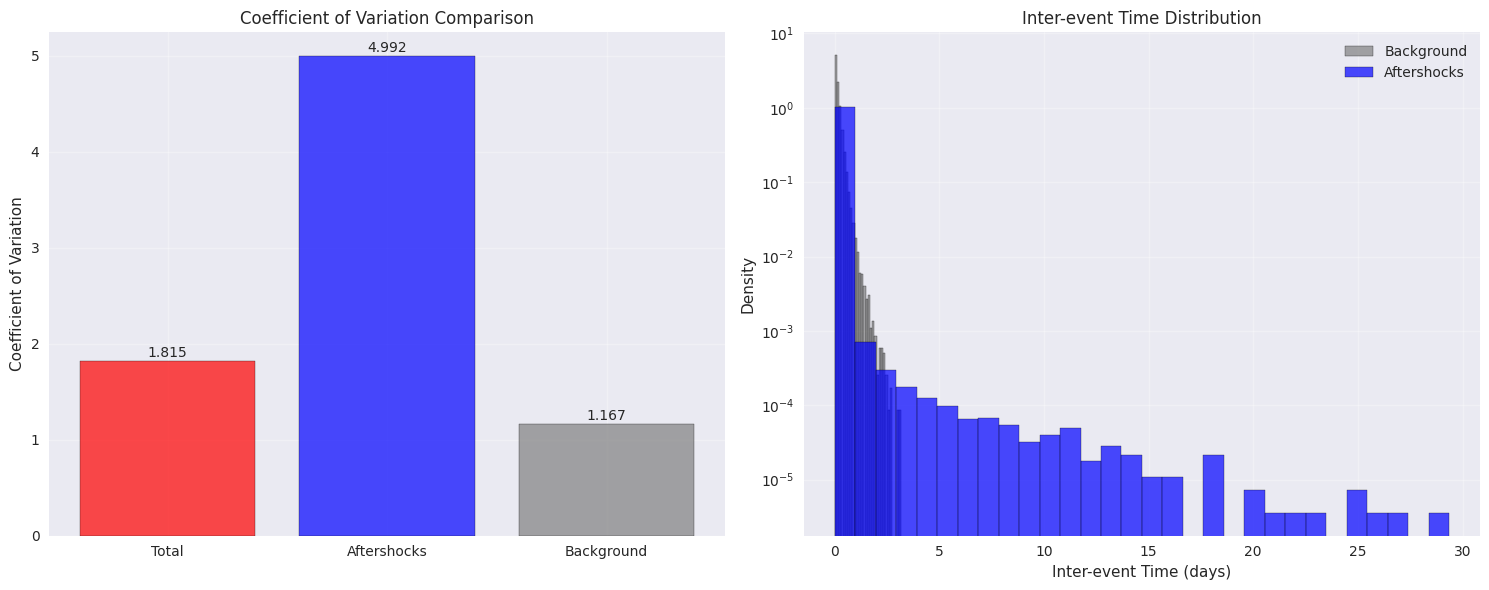

Calculating inter-event time vs distance analysis...


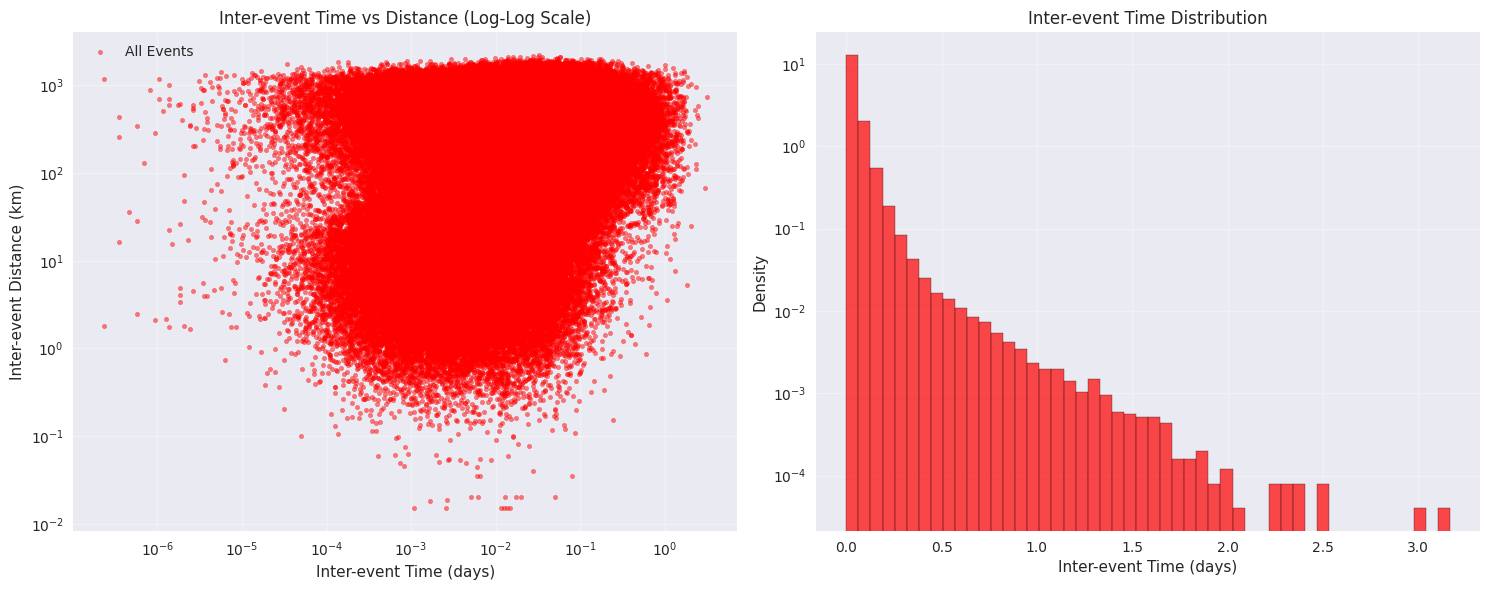

Performing m-Morisita index analysis...
Calculating m-Morisita index...


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class SOMDBSCANEarthquakeClustering:
    def __init__(self):
        self.som_grid_size = None
        self.som_weights = None
        self.spatial_zones = None
        self.aftershocks = None
        self.background = None
        self.clusters = None
        
    def load_data(self, filename):
        """Load and preprocess earthquake data"""
        print("Loading earthquake data...")
        df = pd.read_csv(filename)
        
        # Convert date and time to datetime
        df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
        df['time_days'] = (df['datetime'] - df['datetime'].min()).dt.total_seconds() / (24 * 3600)
        
        # Sort by datetime
        df = df.sort_values('datetime').reset_index(drop=True)
        
        print(f"Loaded {len(df)} earthquake events")
        print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
        print(f"Magnitude range: {df['magnitude'].min():.1f} to {df['magnitude'].max():.1f}")
        
        return df
    
    def plot_initial_distribution(self, df):
        """Plot initial earthquake distribution"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Spatial distribution
        scatter = axes[0,0].scatter(df['longitude'], df['latitude'], 
                                 c=df['depth'], s=df['magnitude']**2, 
                                 alpha=0.6, cmap='viridis_r')
        axes[0,0].set_xlabel('Longitude')
        axes[0,0].set_ylabel('Latitude')
        axes[0,0].set_title('Spatial Distribution of Earthquakes\n(size=magnitude², color=depth)')
        plt.colorbar(scatter, ax=axes[0,0], label='Depth (km)')
        
        # Magnitude distribution
        axes[0,1].hist(df['magnitude'], bins=30, alpha=0.7, edgecolor='black')
        axes[0,1].set_xlabel('Magnitude')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].set_title('Magnitude Distribution')
        
        # Depth distribution
        axes[1,0].hist(df['depth'], bins=30, alpha=0.7, edgecolor='black')
        axes[1,0].set_xlabel('Depth (km)')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].set_title('Depth Distribution')
        
        # Time series
        df_monthly = df.groupby(df['datetime'].dt.to_period('M')).size()
        axes[1,1].plot(df_monthly.index.to_timestamp(), df_monthly.values)
        axes[1,1].set_xlabel('Time')
        axes[1,1].set_ylabel('Number of Events')
        axes[1,1].set_title('Temporal Distribution')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig('initial_earthquake_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def euclidean_distance_3d(self, lat1, lon1, depth1, lat2, lon2, depth2):
        """Calculate 3D Euclidean distance between earthquake events"""
        # Convert to radians for lat/lon
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        
        # Earth radius
        R = 6371.0  # km
        
        # Haversine distance for surface
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        surface_dist = 2 * R * np.arcsin(np.sqrt(a))
        
        # 3D distance including depth
        depth_diff = depth2 - depth1
        distance_3d = np.sqrt(surface_dist**2 + depth_diff**2)
        
        return distance_3d
    
    def som_training(self, df, grid_size=(6, 6), learning_rate=0.1, iterations=100):
        """Implement SOM training algorithm"""
        print(f"Training SOM with grid size {grid_size}...")
        
        # Prepare input data (latitude, longitude, depth)
        input_data = df[['latitude', 'longitude', 'depth']].values
        input_data = StandardScaler().fit_transform(input_data)
        
        # Initialize SOM weights randomly
        n_features = input_data.shape[1]
        weights = np.random.random((grid_size[0] * grid_size[1], n_features))
        
        # Training parameters
        initial_radius = max(grid_size) / 2
        time_constant = iterations / np.log(initial_radius)
        
        quantization_errors = []
        
        for iteration in range(iterations):
            # Decay learning rate and neighborhood radius
            current_learning_rate = learning_rate * np.exp(-iteration / iterations)
            current_radius = initial_radius * np.exp(-iteration / time_constant)
            
            total_error = 0
            
            for input_vector in input_data:
                # Find best matching unit (BMU)
                distances = np.linalg.norm(weights - input_vector, axis=1)
                bmu_idx = np.argmin(distances)
                total_error += distances[bmu_idx]
                
                # Update weights
                for i, weight in enumerate(weights):
                    # Calculate grid distance to BMU
                    bmu_row, bmu_col = divmod(bmu_idx, grid_size[1])
                    node_row, node_col = divmod(i, grid_size[1])
                    grid_dist = np.sqrt((bmu_row - node_row)**2 + (bmu_col - node_col)**2)
                    
                    # Calculate influence
                    if grid_dist <= current_radius:
                        influence = np.exp(-(grid_dist**2) / (2 * current_radius**2))
                        weights[i] += current_learning_rate * influence * (input_vector - weight)
            
            quantization_errors.append(total_error / len(input_data))
            
            if (iteration + 1) % 20 == 0:
                print(f"Iteration {iteration + 1}/{iterations}, QE: {quantization_errors[-1]:.4f}")
        
        self.som_weights = weights.reshape(grid_size[0], grid_size[1], n_features)
        self.som_grid_size = grid_size
        
        # Plot quantization error
        plt.figure(figsize=(10, 6))
        plt.plot(quantization_errors)
        plt.xlabel('Iteration')
        plt.ylabel('Quantization Error')
        plt.title('SOM Training - Quantization Error vs Iterations')
        plt.grid(True, alpha=0.3)
        plt.savefig('som_quantization_error.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return quantization_errors
    
    def assign_to_som_nodes(self, df):
        """Assign earthquakes to SOM nodes"""
        print("Assigning earthquakes to SOM nodes...")
        
        input_data = df[['latitude', 'longitude', 'depth']].values
        input_data = StandardScaler().fit_transform(input_data)
        
        # Flatten SOM weights for distance calculation
        weights_flat = self.som_weights.reshape(-1, self.som_weights.shape[-1])
        
        node_assignments = []
        for input_vector in input_data:
            distances = np.linalg.norm(weights_flat - input_vector, axis=1)
            bmu_idx = np.argmin(distances)
            node_assignments.append(bmu_idx)
        
        df['som_node'] = node_assignments
        
        # Calculate hits per node
        hits_per_node = df['som_node'].value_counts().sort_index()
        
        return df, hits_per_node
    
    def plot_som_results(self, df, hits_per_node):
        """Plot SOM results"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # SOM Hits visualization
        hits_grid = np.zeros(self.som_grid_size)
        for node_idx, hits in hits_per_node.items():
            row, col = divmod(node_idx, self.som_grid_size[1])
            hits_grid[row, col] = hits
        
        im1 = axes[0,0].imshow(hits_grid, cmap='YlOrRd', aspect='equal')
        axes[0,0].set_title('SOM Hits (Number of events per node)')
        plt.colorbar(im1, ax=axes[0,0])
        
        # Add text annotations
        for i in range(self.som_grid_size[0]):
            for j in range(self.som_grid_size[1]):
                node_idx = i * self.som_grid_size[1] + j
                hits = hits_per_node.get(node_idx, 0)
                axes[0,0].text(j, i, str(hits), ha='center', va='center', 
                             color='white' if hits > hits_per_node.max()/2 else 'black')
        
        # SOM node weights spatial distribution
        weights_flat = self.som_weights.reshape(-1, 3)
        scaler = StandardScaler()
        original_data = df[['latitude', 'longitude', 'depth']].values
        scaler.fit(original_data)
        weights_original = scaler.inverse_transform(weights_flat)
        
        scatter = axes[0,1].scatter(weights_original[:, 1], weights_original[:, 0], 
                                  c=weights_original[:, 2], s=100, cmap='viridis_r', 
                                  marker='s', edgecolors='black', linewidth=1)
        axes[0,1].scatter(df['longitude'], df['latitude'], alpha=0.3, s=1, color='gray')
        axes[0,1].set_xlabel('Longitude')
        axes[0,1].set_ylabel('Latitude')
        axes[0,1].set_title('SOM Prototypes (squares) vs Original Data (gray dots)')
        plt.colorbar(scatter, ax=axes[0,1], label='Depth (km)')
        
        # Node assignment distribution
        axes[1,0].bar(range(len(hits_per_node)), hits_per_node.values)
        axes[1,0].set_xlabel('SOM Node Index')
        axes[1,0].set_ylabel('Number of Events')
        axes[1,0].set_title('Events per SOM Node')
        
        # Spatial zones colored by SOM node
        unique_nodes = df['som_node'].unique()
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_nodes)))
        
        for i, node in enumerate(unique_nodes):
            node_data = df[df['som_node'] == node]
            axes[1,1].scatter(node_data['longitude'], node_data['latitude'], 
                            c=[colors[i]], label=f'Zone {node}', s=10, alpha=0.7)
        
        axes[1,1].set_xlabel('Longitude')
        axes[1,1].set_ylabel('Latitude')
        axes[1,1].set_title('Spatial Zones (SOM Clusters)')
        axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
        
        plt.tight_layout()
        plt.savefig('som_analysis_results.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def temporal_dbscan_clustering(self, df, eps=1.0, min_samples=3):
        """Apply DBSCAN clustering in temporal domain for each spatial zone"""
        print("Applying temporal DBSCAN clustering...")
        
        all_labels = np.full(len(df), -1)  # Initialize all as noise (-1)
        cluster_id = 0
        cluster_info = []
        
        # Process each SOM node separately
        for node in df['som_node'].unique():
            node_data = df[df['som_node'] == node].copy()
            
            if len(node_data) < min_samples:
                continue
            
            # Temporal clustering using time_days
            time_data = node_data['time_days'].values.reshape(-1, 1)
            
            # Apply DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(time_data)
            
            # Update global labels
            node_indices = node_data.index
            for i, label in enumerate(labels):
                if label != -1:  # Not noise
                    all_labels[node_indices[i]] = cluster_id + label
            
            # Update cluster_id for next node
            if len(set(labels)) > 1:  # Has clusters (not all noise)
                max_label = max([l for l in labels if l != -1])
                cluster_info.append({
                    'som_node': node,
                    'n_clusters': max_label + 1,
                    'n_events': len(node_data),
                    'n_clustered': sum(labels != -1),
                    'n_background': sum(labels == -1)
                })
                cluster_id += max_label + 1
        
        df['cluster_label'] = all_labels
        
        # Separate aftershocks and background events
        aftershocks = df[df['cluster_label'] != -1].copy()
        background = df[df['cluster_label'] == -1].copy()
        
        print(f"Total events: {len(df)}")
        print(f"Aftershocks: {len(aftershocks)} ({len(aftershocks)/len(df)*100:.1f}%)")
        print(f"Background: {len(background)} ({len(background)/len(df)*100:.1f}%)")
        print(f"Number of clusters: {len(aftershocks['cluster_label'].unique()) if len(aftershocks) > 0 else 0}")
        
        self.aftershocks = aftershocks
        self.background = background
        self.clusters = cluster_info
        
        return df, aftershocks, background
    
    def plot_clustering_results(self, df, aftershocks, background):
        """Plot clustering results"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Spatial distribution of clusters and background
        if len(aftershocks) > 0:
            axes[0,0].scatter(aftershocks['longitude'], aftershocks['latitude'], 
                            c='blue', s=20, alpha=0.7, label='Aftershocks')
        
        if len(background) > 0:
            axes[0,0].scatter(background['longitude'], background['latitude'], 
                            c='gray', s=20, alpha=0.5, label='Background')
        
        axes[0,0].set_xlabel('Longitude')
        axes[0,0].set_ylabel('Latitude')
        axes[0,0].set_title('Spatial Distribution: Aftershocks vs Background Events')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Temporal distribution
        total_monthly = df.groupby(df['datetime'].dt.to_period('M')).size()
        if len(aftershocks) > 0:
            af_monthly = aftershocks.groupby(aftershocks['datetime'].dt.to_period('M')).size()
            af_monthly = af_monthly.reindex(total_monthly.index, fill_value=0)
        else:
            af_monthly = pd.Series(0, index=total_monthly.index)
        
        if len(background) > 0:
            bg_monthly = background.groupby(background['datetime'].dt.to_period('M')).size()
            bg_monthly = bg_monthly.reindex(total_monthly.index, fill_value=0)
        else:
            bg_monthly = pd.Series(0, index=total_monthly.index)
        
        time_index = total_monthly.index.to_timestamp()
        axes[0,1].plot(time_index, total_monthly.values, 'r-', label='Total Events', linewidth=2)
        axes[0,1].plot(time_index, af_monthly.values, 'b-', label='Aftershocks', linewidth=1.5)
        axes[0,1].plot(time_index, bg_monthly.values, 'k-', label='Background', linewidth=1.5)
        axes[0,1].set_xlabel('Time')
        axes[0,1].set_ylabel('Number of Events per Month')
        axes[0,1].set_title('Temporal Distribution (Lambda Plot)')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # Cumulative plot
        total_cumsum = total_monthly.cumsum()
        af_cumsum = af_monthly.cumsum()
        bg_cumsum = bg_monthly.cumsum()
        
        axes[1,0].plot(time_index, total_cumsum.values, 'r-', label='Total Events', linewidth=2)
        axes[1,0].plot(time_index, af_cumsum.values, 'b-', label='Aftershocks', linewidth=1.5)
        axes[1,0].plot(time_index, bg_cumsum.values, 'k-', label='Background', linewidth=1.5)
        axes[1,0].set_xlabel('Time')
        axes[1,0].set_ylabel('Cumulative Number of Events')
        axes[1,0].set_title('Cumulative Distribution')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # Magnitude vs Time
        axes[1,1].scatter(df['datetime'], df['magnitude'], c='red', s=10, alpha=0.6, label='Total')
        if len(aftershocks) > 0:
            axes[1,1].scatter(aftershocks['datetime'], aftershocks['magnitude'], 
                            c='blue', s=15, alpha=0.8, label='Aftershocks')
        axes[1,1].set_xlabel('Time')
        axes[1,1].set_ylabel('Magnitude')
        axes[1,1].set_title('Magnitude vs Time')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig('clustering_results.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def calculate_coefficient_of_variation(self, df, aftershocks, background):
        """Calculate Coefficient of Variation for temporal analysis"""
        print("Calculating Coefficient of Variation...")
        
        def cov_calculation(event_times):
            if len(event_times) < 2:
                return 0
            
            # Calculate inter-event times in days
            event_times_sorted = np.sort(event_times)
            inter_event_times = np.diff(event_times_sorted)
            
            if len(inter_event_times) == 0:
                return 0
            
            mean_iet = np.mean(inter_event_times)
            std_iet = np.std(inter_event_times)
            
            if mean_iet == 0:
                return 0
            
            return std_iet / mean_iet
        
        # Calculate COV for total, aftershocks, and background
        cov_total = cov_calculation(df['time_days'].values)
        cov_aftershocks = cov_calculation(aftershocks['time_days'].values) if len(aftershocks) > 1 else 0
        cov_background = cov_calculation(background['time_days'].values) if len(background) > 1 else 0
        
        print(f"COV Total: {cov_total:.4f}")
        print(f"COV Aftershocks: {cov_aftershocks:.4f}")
        print(f"COV Background: {cov_background:.4f}")
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # COV comparison
        categories = ['Total', 'Aftershocks', 'Background']
        cov_values = [cov_total, cov_aftershocks, cov_background]
        colors = ['red', 'blue', 'gray']
        
        bars = ax1.bar(categories, cov_values, color=colors, alpha=0.7, edgecolor='black')
        ax1.set_ylabel('Coefficient of Variation')
        ax1.set_title('Coefficient of Variation Comparison')
        ax1.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, cov_values):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')
        
        # Inter-event time distribution
        if len(background) > 1:
            bg_times = np.sort(background['time_days'].values)
            bg_iet = np.diff(bg_times)
            ax2.hist(bg_iet, bins=30, alpha=0.7, color='gray', edgecolor='black', 
                    density=True, label='Background')
        
        if len(aftershocks) > 1:
            af_times = np.sort(aftershocks['time_days'].values)
            af_iet = np.diff(af_times)
            ax2.hist(af_iet, bins=30, alpha=0.7, color='blue', edgecolor='black', 
                    density=True, label='Aftershocks')
        
        ax2.set_xlabel('Inter-event Time (days)')
        ax2.set_ylabel('Density')
        ax2.set_title('Inter-event Time Distribution')
        ax2.set_yscale('log')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('coefficient_of_variation_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return cov_total, cov_aftershocks, cov_background
    
    def plot_interevent_analysis(self, df, aftershocks, background):
        """Plot inter-event time vs inter-event distance analysis"""
        print("Calculating inter-event time vs distance analysis...")
        
        def calculate_iet_ied(data):
            if len(data) < 2:
                return np.array([]), np.array([])
            
            data_sorted = data.sort_values('time_days').reset_index(drop=True)
            
            inter_event_times = []
            inter_event_distances = []
            
            for i in range(1, len(data_sorted)):
                # Time difference in days
                dt = data_sorted.loc[i, 'time_days'] - data_sorted.loc[i-1, 'time_days']
                
                # Distance calculation
                dd = self.euclidean_distance_3d(
                    data_sorted.loc[i-1, 'latitude'], data_sorted.loc[i-1, 'longitude'], data_sorted.loc[i-1, 'depth'],
                    data_sorted.loc[i, 'latitude'], data_sorted.loc[i, 'longitude'], data_sorted.loc[i, 'depth']
                )
                
                inter_event_times.append(dt)
                inter_event_distances.append(dd)
            
            return np.array(inter_event_times), np.array(inter_event_distances)
        
        # Calculate for all events
        total_iet, total_ied = calculate_iet_ied(df)
        
        # Create the plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Log-log plot of IET vs IED
        if len(total_iet) > 0:
            # Remove zero values for log plot
            valid_mask = (total_iet > 0) & (total_ied > 0)
            if np.sum(valid_mask) > 0:
                ax1.scatter(total_iet[valid_mask], total_ied[valid_mask], 
                           alpha=0.5, s=10, c='red', label='All Events')
        
        ax1.set_xlabel('Inter-event Time (days)')
        ax1.set_ylabel('Inter-event Distance (km)')
        ax1.set_title('Inter-event Time vs Distance (Log-Log Scale)')
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Distribution of inter-event times
        if len(total_iet) > 0:
            ax2.hist(total_iet, bins=50, alpha=0.7, color='red', edgecolor='black', density=True)
            ax2.set_xlabel('Inter-event Time (days)')
            ax2.set_ylabel('Density')
            ax2.set_title('Inter-event Time Distribution')
            ax2.set_yscale('log')
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('interevent_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return total_iet, total_ied
    
    def calculate_morisita_index(self, events, m_values=[2, 3, 4, 5], max_d=2.0, n_points=20):
        """Calculate m-Morisita index for spatial clustering analysis"""
        print("Calculating m-Morisita index...")
        
        if len(events) < max(m_values):
            print("Not enough events for Morisita analysis")
            return None, None
        
        # Extract coordinates
        coords = events[['longitude', 'latitude']].values
        N = len(coords)
        
        # Range of quadrat sizes (diagonal lengths)
        d_values = np.logspace(-2, np.log10(max_d), n_points)
        
        morisita_results = {}
        
        for m in m_values:
            Im_values = []
            
            for d in d_values:
                # Create grid
                min_x, max_x = coords[:, 0].min(), coords[:, 0].max()
                min_y, max_y = coords[:, 1].min(), coords[:, 1].max()
                
                # Grid size based on diagonal length d
                grid_size = d / np.sqrt(2)
                
                if grid_size == 0:
                    Im_values.append(1.0)
                    continue
                
                n_x = max(1, int((max_x - min_x) / grid_size) + 1)
                n_y = max(1, int((max_y - min_y) / grid_size) + 1)
                
                Q = n_x * n_y
                
                # Count events in each quadrat
                quadrat_counts = []
                for i in range(n_x):
                    for j in range(n_y):
                        x_min = min_x + i * grid_size
                        x_max = min_x + (i + 1) * grid_size
                        y_min = min_y + j * grid_size
                        y_max = min_y + (j + 1) * grid_size
                        
                        count = np.sum((coords[:, 0] >= x_min) & (coords[:, 0] < x_max) &
                                      (coords[:, 1] >= y_min) & (coords[:, 1] < y_max))
                        quadrat_counts.append(count)
                
                quadrat_counts = np.array(quadrat_counts)
                
                # Calculate m-Morisita index
                numerator = 0
                for ni in quadrat_counts:
                    if ni >= m:
                        product = 1
                        for k in range(m):
                            product *= (ni - k)
                        numerator += product
                
                denominator = 1
                for k in range(m):
                    denominator *= (N - k)
                
                if denominator == 0:
                    Im = 1.0
                else:
                    Im = Q * numerator / denominator
                
                Im_values.append(Im)
            
            morisita_results[m] = Im_values
        
        return d_values, morisita_results
    
    def plot_morisita_analysis(self, df, aftershocks, background):
        """Plot m-Morisita index analysis"""
        print("Performing m-Morisita index analysis...")
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Calculate Morisita index for each dataset
        datasets = [('Total Events', df, 'red'), 
                   ('Aftershocks', aftershocks, 'blue'), 
                   ('Background', background, 'gray')]
        
        for idx, (name, data, color) in enumerate(datasets):
            if len(data) == 0:
                continue
                
            d_values, morisita_results = self.calculate_morisita_index(data)
            
            if morisita_results is None:
                continue
            
            for m in [2, 3, 4, 5]:
                if m in morisita_results:
                    axes[idx].loglog(d_values, morisita_results[m], 
                                   'o-', label=f'm={m}', alpha=0.7, markersize=4)
            
            axes[idx].set_xlabel('Quadrat size d')
            axes[idx].set_ylabel('m-Morisita Index Im,d')
            axes[idx].set_title(f'{name}')
            axes[idx].grid(True, alpha=0.3)
            axes[idx].legend()
            axes[idx].set_ylim(bottom=0.1)
        
        plt.tight_layout()
        plt.savefig('morisita_index_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def generate_summary_report(self, df, aftershocks, background, cov_results):
        """Generate comprehensive summary report"""
        print("\n" + "="*60)
        print("EARTHQUAKE CLUSTERING ANALYSIS SUMMARY REPORT")
        print("="*60)
        
        print(f"\nDATASET OVERVIEW:")
        print(f"Total events: {len(df)}")
        print(f"Date range: {df['datetime'].min().strftime('%Y-%m-%d')} to {df['datetime'].max().strftime('%Y-%m-%d')}")
        print(f"Magnitude range: {df['magnitude'].min():.1f} - {df['magnitude'].max():.1f}")
        print(f"Depth range: {df['depth'].min():.1f} - {df['depth'].max():.1f} km")
        
        print(f"\nSOM CONFIGURATION:")
        print(f"Grid size: {self.som_grid_size}")
        print(f"Number of spatial zones: {len(df['som_node'].unique())}")
        
        print(f"\nCLUSTERING RESULTS:")
        print(f"Aftershocks: {len(aftershocks)} ({len(aftershocks)/len(df)*100:.1f}%)")
        print(f"Background events: {len(background)} ({len(background)/len(df)*100:.1f}%)")
        n_clusters = len(aftershocks['cluster_label'].unique()) if len(aftershocks) > 0 else 0
        print(f"Number of temporal clusters: {n_clusters}")
        
        print(f"\nCOEFFICIENT OF VARIATION ANALYSIS:")
        print(f"COV Total: {cov_results[0]:.4f}")
        print(f"COV Aftershocks: {cov_results[1]:.4f}")
        print(f"COV Background: {cov_results[2]:.4f}")
        
        # Validation checks
        print(f"\nVALIDATION CHECKS:")
        cov_check = "PASS" if cov_results[1] > cov_results[0] > cov_results[2] else "FAIL"
        print(f"COV relationship (AF > Total > BG): {cov_check}")
        
        poisson_check = "PASS" if abs(cov_results[2] - 1.0) < 0.3 else "FAIL"
        print(f"Background Poisson-like (COV ≈ 1): {poisson_check}")
        
        if len(aftershocks) > 0 and len(background) > 0:
            print(f"\nSPATIAL STATISTICS:")
            af_density = len(aftershocks) / ((aftershocks['longitude'].max() - aftershocks['longitude'].min()) * 
                                           (aftershocks['latitude'].max() - aftershocks['latitude'].min()))
            bg_density = len(background) / ((background['longitude'].max() - background['longitude'].min()) * 
                                          (background['latitude'].max() - background['latitude'].min()))
            print(f"Aftershock spatial density: {af_density:.2f} events/deg²")
            print(f"Background spatial density: {bg_density:.2f} events/deg²")
        
        print("\n" + "="*60)
    
    def run_complete_analysis(self, filename, som_grid=(6,6), dbscan_eps=1.0, dbscan_min_samples=3):
        """Run complete SOM-DBSCAN analysis pipeline"""
        print("Starting complete earthquake clustering analysis...")
        print("="*60)
        
        # Load data
        df = self.load_data(filename)
        
        # Initial visualization
        self.plot_initial_distribution(df)
        
        # SOM training
        self.som_training(df, grid_size=som_grid)
        
        # Assign events to SOM nodes
        df, hits_per_node = self.assign_to_som_nodes(df)
        
        # Plot SOM results
        self.plot_som_results(df, hits_per_node)
        
        # Temporal clustering
        df, aftershocks, background = self.temporal_dbscan_clustering(df, eps=dbscan_eps, min_samples=dbscan_min_samples)
        
        # Plot clustering results
        self.plot_clustering_results(df, aftershocks, background)
        
        # Statistical analysis
        cov_results = self.calculate_coefficient_of_variation(df, aftershocks, background)
        
        # Inter-event analysis
        self.plot_interevent_analysis(df, aftershocks, background)
        
        # Morisita index analysis
        self.plot_morisita_analysis(df, aftershocks, background)
        
        # Generate summary report
        self.generate_summary_report(df, aftershocks, background, cov_results)
        
        # Save results
        df.to_csv('earthquake_analysis_results.csv', index=False)
        if len(aftershocks) > 0:
            aftershocks.to_csv('aftershocks_identified.csv', index=False)
        if len(background) > 0:
            background.to_csv('background_events.csv', index=False)
        
        print("\nAnalysis complete! Results saved to CSV files and PNG plots.")
        
        return df, aftershocks, background


# Usage example and main execution
if __name__ == "__main__":
    # Initialize the clustering system
    earthquake_analyzer = SOMDBSCANEarthquakeClustering()
    
    # Run complete analysis on New Zealand data
    # Adjust parameters as needed based on your dataset characteristics
    try:
        df_results, aftershocks_results, background_results = earthquake_analyzer.run_complete_analysis(
            filename='../../data/processed/data.csv',
            som_grid=(6, 6),        # SOM grid size - adjust based on spatial distribution
            dbscan_eps=1.0,         # DBSCAN epsilon (days) - temporal clustering sensitivity
            dbscan_min_samples=3    # Minimum events for a cluster
        )
        
        # Additional analysis if needed
        print("\nAdditional statistics:")
        print(f"Largest aftershock cluster: {aftershocks_results['cluster_label'].value_counts().iloc[0] if len(aftershocks_results) > 0 else 0} events")
        print(f"Average cluster size: {len(aftershocks_results)/len(aftershocks_results['cluster_label'].unique()) if len(aftershocks_results) > 0 else 0:.1f} events")
        
        # Plot magnitude distribution comparison
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        if len(aftershocks_results) > 0:
            plt.hist(aftershocks_results['magnitude'], bins=20, alpha=0.7, 
                    label='Aftershocks', color='blue', edgecolor='black')
        if len(background_results) > 0:
            plt.hist(background_results['magnitude'], bins=20, alpha=0.7, 
                    label='Background', color='gray', edgecolor='black')
        plt.xlabel('Magnitude')
        plt.ylabel('Frequency')
        plt.title('Magnitude Distribution Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        if len(aftershocks_results) > 0:
            plt.hist(aftershocks_results['depth'], bins=20, alpha=0.7, 
                    label='Aftershocks', color='blue', edgecolor='black')
        if len(background_results) > 0:
            plt.hist(background_results['depth'], bins=20, alpha=0.7, 
                    label='Background', color='gray', edgecolor='black')
        plt.xlabel('Depth (km)')
        plt.ylabel('Frequency')
        plt.title('Depth Distribution Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('magnitude_depth_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    except FileNotFoundError:
        print("Error: 'data.csv' file not found. Please ensure your New Zealand earthquake data is saved as 'data.csv' in the current directory.")
        print("Expected columns: ['date', 'time', 'latitude', 'longitude', 'depth', 'magnitude']")
    
    except Exception as e:
        print(f"An error occurred during analysis: {str(e)}")
        print("Please check your data format and try again.")

## Quantization Error Vs Iterations

Iteration 20/100, QE: 0.3336

Iteration 40/100, QE: 0.2546

Iteration 60/100, QE: 0.2506

Iteration 80/100, QE: 0.2117

Iteration 100/100, QE: 0.2084



In [16]:
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df

,date,time,latitude,longitude,depth,magnitude,zone_id,datetime
0,1980-01-01,07:04:05.60,-41.287000,175.235000,26.100000,2.567000,6,1980-01-01 07:04:05.600
1,1980-01-01,09:27:04.52,-40.490000,174.669010,72.600000,3.200000,14,1980-01-01 09:27:04.520
2,1980-01-01,18:28:10.99,-37.630000,176.380000,210.000000,4.150000,34,1980-01-01 18:28:10.990
3,1980-01-01,20:20:54.03,-40.290000,173.429990,212.000000,4.500000,33,1980-01-01 20:20:54.030
4,1980-01-02,18:24:15.40,-38.480000,176.750000,5.000000,3.375000,3,1980-01-02 18:24:15.400
...,...,...,...,...,...,...,...,...
396266,2024-12-31,18:31:44.72,-45.076202,167.357101,74.645035,2.920129,31,2024-12-31 18:31:44.720
396267,2024-12-31,20:37:56.20,-37.985142,176.407059,133.171555,2.605564,28,2024-12-31 20:37:56.200
396268,2024-12-31,21:24:08.59,-38.524281,175.719986,157.843369,2.570573,27,2024-12-31 21:24:08.590
396269,2024-12-31,23:26:03.90,-38.329933,178.956192,12.000000,2.406177,3,2024-12-31 23:26:03.900


# Phase I - Spatial Zoning with a Self-Organizing Map (SOM)

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Spatial features

features=df[["latitude","longitude","depth"]].values

# Normalize the features to a [0,1] range

scaler=MinMaxScaler()
features_scaled=scaler.fit_transform(features)

## Train the SOM:

In [13]:
from minisom import MiniSom

# SOM Parametes

som_grid_rows=6
som_grid_cols=6
input_len=features_scaled.shape[1]  # Should be 3(lat,lon,depth)

# Initialize and train the som

som=MiniSom(som_grid_rows,som_grid_cols,input_len,sigma=1.0,learning_rate=0.5,
            neighborhood_function="gaussian",random_seed=42)

som.random_weights_init(features_scaled)

print("\n Training the SOM.........")
som.train_random(features_scaled,10000)   # No of iteration is 100
print("SOM Training complete.")

#Each neuron in the SOM is now a "prototype" for a spatial zone
# Get the weights (prototypes) and un-scale them to their original values
zone_prototypes = scaler.inverse_transform(som.get_weights().reshape(-1, input_len))



 Training the SOM.........
SOM Training complete.


In [30]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 8))
for x in features_scaled:
    w = som.winner(x)  # neuron that best matches x
    plt.plot(w[0]+0.5, w[1]+0.5, 'ro', markersize=4, alpha=0.5)

plt.title("Earthquake Mapping on SOM Grid")
plt.show()


: 

##  Assign Events to Zones

##### Each earthquake in our catalog now needs to be assigned to the closest SOM prototype. This groups our data into the seismic zones.


In [17]:
# For each event, find the best matching unit (BMU) or winning neuron
winner_coordinates = np.array([som.winner(x) for x in features_scaled]).T

# Create a 'zone_id' for each event based on its winning neuron
df['zone_id'] = np.ravel_multi_index(winner_coordinates, (som_grid_rows, som_grid_cols))

print(f"\nAssigned {len(df['zone_id'].unique())} unique seismic zones.")


Assigned 33 unique seismic zones.


In [18]:
df

,date,time,latitude,longitude,depth,magnitude,zone_id,datetime
0,1980-01-01,07:04:05.60,-41.287000,175.235000,26.100000,2.567000,6,1980-01-01 07:04:05.600
1,1980-01-01,09:27:04.52,-40.490000,174.669010,72.600000,3.200000,14,1980-01-01 09:27:04.520
2,1980-01-01,18:28:10.99,-37.630000,176.380000,210.000000,4.150000,34,1980-01-01 18:28:10.990
3,1980-01-01,20:20:54.03,-40.290000,173.429990,212.000000,4.500000,33,1980-01-01 20:20:54.030
4,1980-01-02,18:24:15.40,-38.480000,176.750000,5.000000,3.375000,3,1980-01-02 18:24:15.400
...,...,...,...,...,...,...,...,...
396266,2024-12-31,18:31:44.72,-45.076202,167.357101,74.645035,2.920129,31,2024-12-31 18:31:44.720
396267,2024-12-31,20:37:56.20,-37.985142,176.407059,133.171555,2.605564,28,2024-12-31 20:37:56.200
396268,2024-12-31,21:24:08.59,-38.524281,175.719986,157.843369,2.570573,27,2024-12-31 21:24:08.590
396269,2024-12-31,23:26:03.90,-38.329933,178.956192,12.000000,2.406177,3,2024-12-31 23:26:03.900


In [3]:
#!/usr/bin/env python3
"""
som_dbscan_declustering_memory_friendly_noMc.py

Memory-efficient SOM + temporal-DBSCAN declustering.
- Assumes catalog is already filtered by Mc
- Chunked BMU assignment
- Custom 1D DBSCAN for temporal clustering per SOM zone
- Sequential zone processing (low memory)
- Saves intermediate and final results

Usage:
    pip install numpy pandas matplotlib minisom
    python som_dbscan_declustering_memory_friendly_noMc.py /path/to/catalog.csv
"""

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
from math import radians
from collections import deque

# ---------- constants ----------
RE_KM = 6371.0

# ---------- utilities ----------
def load_catalog(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = [c.strip() for c in df.columns]
    required = ['time', 'latitude', 'longitude', 'depth', 'magnitude']
    for c in required:
        if c not in df.columns:
            raise ValueError(f"Catalog missing required column: {c}")
    df['time'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df = df.dropna(subset=['time'])
    df = df.sort_values('time').reset_index(drop=True)
    return df

def latlon_depth_to_ecef(lat_deg, lon_deg, depth_km):
    lat = np.radians(lat_deg)
    lon = np.radians(lon_deg)
    r = RE_KM - depth_km
    x = r * np.cos(lat) * np.cos(lon)
    y = r * np.cos(lat) * np.sin(lon)
    z = r * np.sin(lat)
    return np.vstack([x, y, z]).T.astype(np.float32)

# ---------- SOM helpers ----------
def quantization_error(som, data):
    weights = som.get_weights().reshape(-1, data.shape[1])
    N = data.shape[0]
    chunk = 50000
    tot = 0.0
    count = 0
    for i in range(0, N, chunk):
        block = data[i:i+chunk]
        diff = block[:, None, :] - weights[None, :, :]
        d = np.linalg.norm(diff, axis=2)
        tot += d.min(axis=1).sum()
        count += block.shape[0]
    return tot / count

def choose_som_grid_and_train(data_xyz, candidate_sizes=[(5,5),(6,6),(7,7)], 
                             iters=200, sigma=1.0, learning_rate=0.1, random_seed=42):
    results = []
    for size in candidate_sizes:
        xdim, ydim = size
        print(f"Training SOM {size} ...")
        som = MiniSom(xdim, ydim, data_xyz.shape[1], sigma=sigma, learning_rate=learning_rate,
                      neighborhood_function='gaussian', random_seed=random_seed)
        som.random_weights_init(data_xyz)
        som.train_random(data_xyz, iters)
        qe = quantization_error(som, data_xyz)
        results.append({'size':size, 'som':som, 'qe':qe})
        print(f"  QE={qe:.4f}")
    best = min(results, key=lambda r: r['qe'])
    print("Selected SOM grid:", best['size'], "QE:", best['qe'])
    return best['som'], results

def bmu_assign_chunked(som, data_xyz, chunk_size=50000):
    weights = som.get_weights().reshape(-1, data_xyz.shape[1])
    xdim, ydim = som.get_weights().shape[:2]
    N = data_xyz.shape[0]
    winners = np.empty((N,2), dtype=np.int32)
    for i in range(0, N, chunk_size):
        block = data_xyz[i:i+chunk_size]
        diff = block[:, None, :] - weights[None, :, :]
        d = np.linalg.norm(diff, axis=2)
        idx = d.argmin(axis=1)
        x_idx = idx // ydim
        y_idx = idx % ydim
        winners[i:i+block.shape[0],0] = x_idx
        winners[i:i+block.shape[0],1] = y_idx
    return winners

# ---------- 1D DBSCAN ----------
def dbscan_1d_times(times_days, eps, min_samples):
    n = len(times_days)
    if n == 0:
        return np.array([], dtype=int)
    if n < min_samples:
        return np.full(n, -1, dtype=int)
    order = np.argsort(times_days)
    times_sorted = times_days[order]
    L = np.empty(n, dtype=np.int32)
    R = np.empty(n, dtype=np.int32)
    j = 0
    for i in range(n):
        if j < i:
            j = i
        while j+1 < n and times_sorted[j+1] - times_sorted[i] <= eps:
            j += 1
        R[i] = j
    j = 0
    for i in range(n):
        while j < i and times_sorted[i] - times_sorted[j] > eps:
            j += 1
        L[i] = j
    neigh_count = (R - L + 1)
    core = neigh_count >= min_samples
    labels_sorted = np.full(n, -1, dtype=int)
    cluster_id = 0
    visited = np.zeros(n, dtype=bool)
    for i in range(n):
        if visited[i] or not core[i]:
            continue
        queue = deque([i])
        visited[i] = True
        labels_sorted[i] = cluster_id
        while queue:
            u = queue.popleft()
            for v in range(L[u], R[u]+1):
                if not visited[v]:
                    visited[v] = True
                    labels_sorted[v] = cluster_id
                    if core[v]:
                        queue.append(v)
        cluster_id += 1
    for idx_unl in np.where(labels_sorted == -1)[0]:
        for v in range(L[idx_unl], R[idx_unl]+1):
            if core[v] and labels_sorted[v] != -1:
                labels_sorted[idx_unl] = labels_sorted[v]
                break
    labels = np.full(n, -1, dtype=int)
    labels[order] = labels_sorted
    return labels

# ---------- Validation ----------
def compute_iet_ied(df):
    df_sorted = df.sort_values('time').reset_index(drop=True)
    if len(df_sorted) < 2:
        return np.array([]), np.array([])
    iet = df_sorted['time'].diff().dt.total_seconds().values[1:] / 86400.0
    lat1 = np.radians(df_sorted['latitude'].values[:-1])
    lat2 = np.radians(df_sorted['latitude'].values[1:])
    lon1 = np.radians(df_sorted['longitude'].values[:-1])
    lon2 = np.radians(df_sorted['longitude'].values[1:])
    cosval = np.sin(lat1)*np.sin(lat2) + np.cos(lat1)*np.cos(lat2)*np.cos(lon1-lon2)
    cosval = np.clip(cosval, -1.0, 1.0)
    Rij = RE_KM * np.arccos(cosval)
    dz = df_sorted['depth'].values[1:] - df_sorted['depth'].values[:-1]
    ied = np.sqrt(Rij**2 + dz**2)
    return iet, ied

def compute_cov(interevent_times_days):
    if len(interevent_times_days) == 0:
        return np.nan
    mu = np.mean(interevent_times_days)
    sigma = np.std(interevent_times_days, ddof=0)
    return sigma / mu if mu != 0 else np.nan

# ---------- main pipeline ----------
def run_pipeline(csv_path, outdir='results', som_candidates=[(5,5),(6,6),(7,7)],
                 som_iters=200, som_sigma=2.0, som_lr=0.1, eps_days=1.0, min_samples=3,
                 bmu_chunk=50000):
    os.makedirs(outdir, exist_ok=True)
    df = load_catalog(csv_path)
    print("Loaded", len(df), "events (already Mc filtered)")
    coords_ecef = latlon_depth_to_ecef(df['latitude'].values, df['longitude'].values, df['depth'].values)
    som, candidate_results = choose_som_grid_and_train(coords_ecef, candidate_sizes=som_candidates,
                                                       iters=som_iters, sigma=som_sigma, learning_rate=som_lr)
    print("Assigning BMUs ...")
    winners = bmu_assign_chunked(som, coords_ecef, chunk_size=bmu_chunk)
    xdim, ydim = som.get_weights().shape[:2]
    zone_ids = winners[:,0] * ydim + winners[:,1]
    df['som_zone'] = zone_ids
    global_cluster_ids = np.full(len(df), -1, dtype=np.int64)
    for zone in np.unique(zone_ids):
        idxs = np.flatnonzero(zone_ids == zone)
        times = df['time'].iloc[idxs].values
        t0 = times.min()
        times_days = (times - t0).astype('timedelta64[s]').astype(np.float64) / 86400.0
        labels_zone = dbscan_1d_times(times_days, eps=eps_days, min_samples=min_samples)
        for local_pos, orig_index in enumerate(idxs):
            lab = labels_zone[local_pos]
            if lab != -1:
                global_cluster_ids[orig_index] = (int(zone) << 20) + int(lab)
    df['global_cluster'] = global_cluster_ids
    df['is_aftershock'] = (df['global_cluster'] != -1).astype(int)
    out_csv = os.path.join(outdir, 'catalog_declustered.csv')
    df.to_csv(out_csv, index=False)
    print("Saved declustered catalog to", out_csv)
    iet_total, ied_total = compute_iet_ied(df)
    print("COV Total:", compute_cov(iet_total))
    print("Number of clusters:", len(np.unique(global_cluster_ids[global_cluster_ids!=-1])))

# ---------- entry ----------
if __name__ == "__main__":
    if len(sys.argv) < 2:
        print("Usage: python som_dbscan_declustering_memory_friendly_noMc.py /path/to/catalog.csv")
        sys.exit(1)
    csv_path = '../../data/processed/data.csv'

    run_pipeline(csv_path, outdir='results', som_candidates=[(5,5),(6,6),(7,7)],
                 som_iters=200, som_sigma=2.0, som_lr=0.1, eps_days=1.0, min_samples=3,
                 bmu_chunk=50000)


Loaded 396271 events (already Mc filtered)
Training SOM (5, 5) ...
  QE=126.2415
Training SOM (6, 6) ...
  QE=109.1663
Training SOM (7, 7) ...
  QE=112.0925
Selected SOM grid: (6, 6) QE: 109.16631676810616
Assigning BMUs ...
Saved declustered catalog to results/catalog_declustered.csv
COV Total: 1.8147287359684647
Number of clusters: 23110


# Cloude

#  Phase II - Temporal Clustering with T-DBSCAN 

,date,time,latitude,longitude,depth,magnitude
0,1980-01-01,07:04:05.60,-41.287000,175.235000,26.100000,2.567000
1,1980-01-01,09:27:04.52,-40.490000,174.669010,72.600000,3.200000
2,1980-01-01,18:28:10.99,-37.630000,176.380000,210.000000,4.150000
3,1980-01-01,20:20:54.03,-40.290000,173.429990,212.000000,4.500000
4,1980-01-02,18:24:15.40,-38.480000,176.750000,5.000000,3.375000
...,...,...,...,...,...,...
396266,2024-12-31,18:31:44.72,-45.076202,167.357101,74.645035,2.920129
396267,2024-12-31,20:37:56.20,-37.985142,176.407059,133.171555,2.605564
396268,2024-12-31,21:24:08.59,-38.524281,175.719986,157.843369,2.570573
396269,2024-12-31,23:26:03.90,-38.329933,178.956192,12.000000,2.406177


# Cloude

In [1]:
data=pd.read_csv("../../data/processed/data.csv")
df_load=data.copy()
df_load


NameError: name 'pd' is not defined

In [7]:
df = df_load[df_load["magnitude"] > 4.85]
n=len(df)
n

2568

In [8]:
df.to_csv("Modified_data.csv", index=False)


2025-09-14 08:25:28,983 - INFO - ============================================================
2025-09-14 08:25:28,984 - INFO - ENHANCED SOM + DBSCAN DECLUSTERING PIPELINE
2025-09-14 08:25:28,984 - INFO - ============================================================
2025-09-14 08:25:28,985 - INFO - Step 1: Loading and validating catalog...
2025-09-14 08:25:28,985 - INFO - Loading catalog from Modified_data.csv
2025-09-14 08:25:28,996 - INFO - Loaded 2568/2568 valid events
2025-09-14 08:25:28,998 - INFO - Time range: 1980-01-24 10:15:50.300000 to 2024-12-25 16:09:52.770000
2025-09-14 08:25:28,999 - INFO - Magnitude range: 4.9 to 7.8
2025-09-14 08:25:29,000 - INFO - Step 2: Converting coordinates to ECEF...
2025-09-14 08:25:29,001 - INFO - Step 3: Training Self-Organizing Map...
2025-09-14 08:25:29,002 - INFO - Training SOM candidates...
SOM Grid Search: 100%|██████████| 5/5 [00:33<00:00,  6.67s/it]
2025-09-14 08:26:02,360 - INFO - Selected SOM grid: (6, 6) (QE=0.2940, TE=0.2449)
2025-09-1

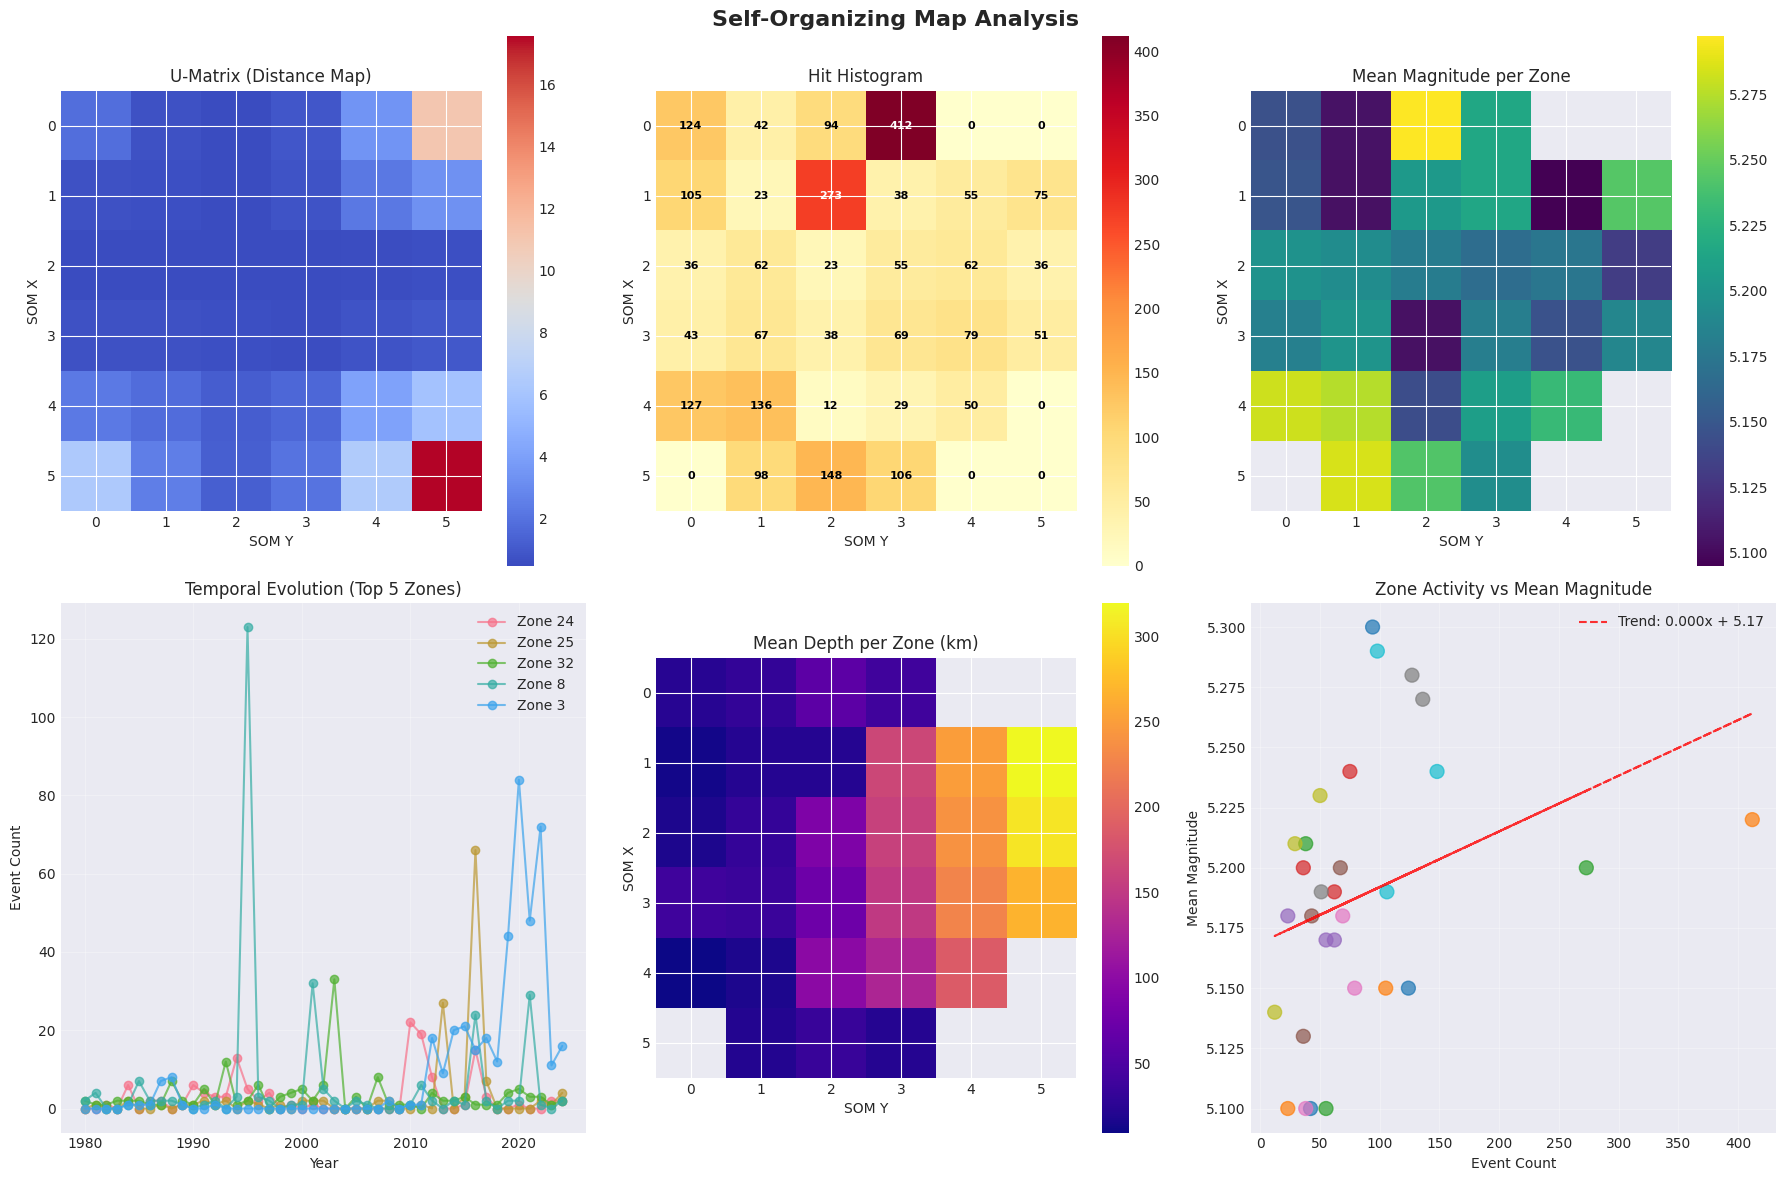

2025-09-14 08:26:06,085 - INFO - Creating clustering visualization plots...


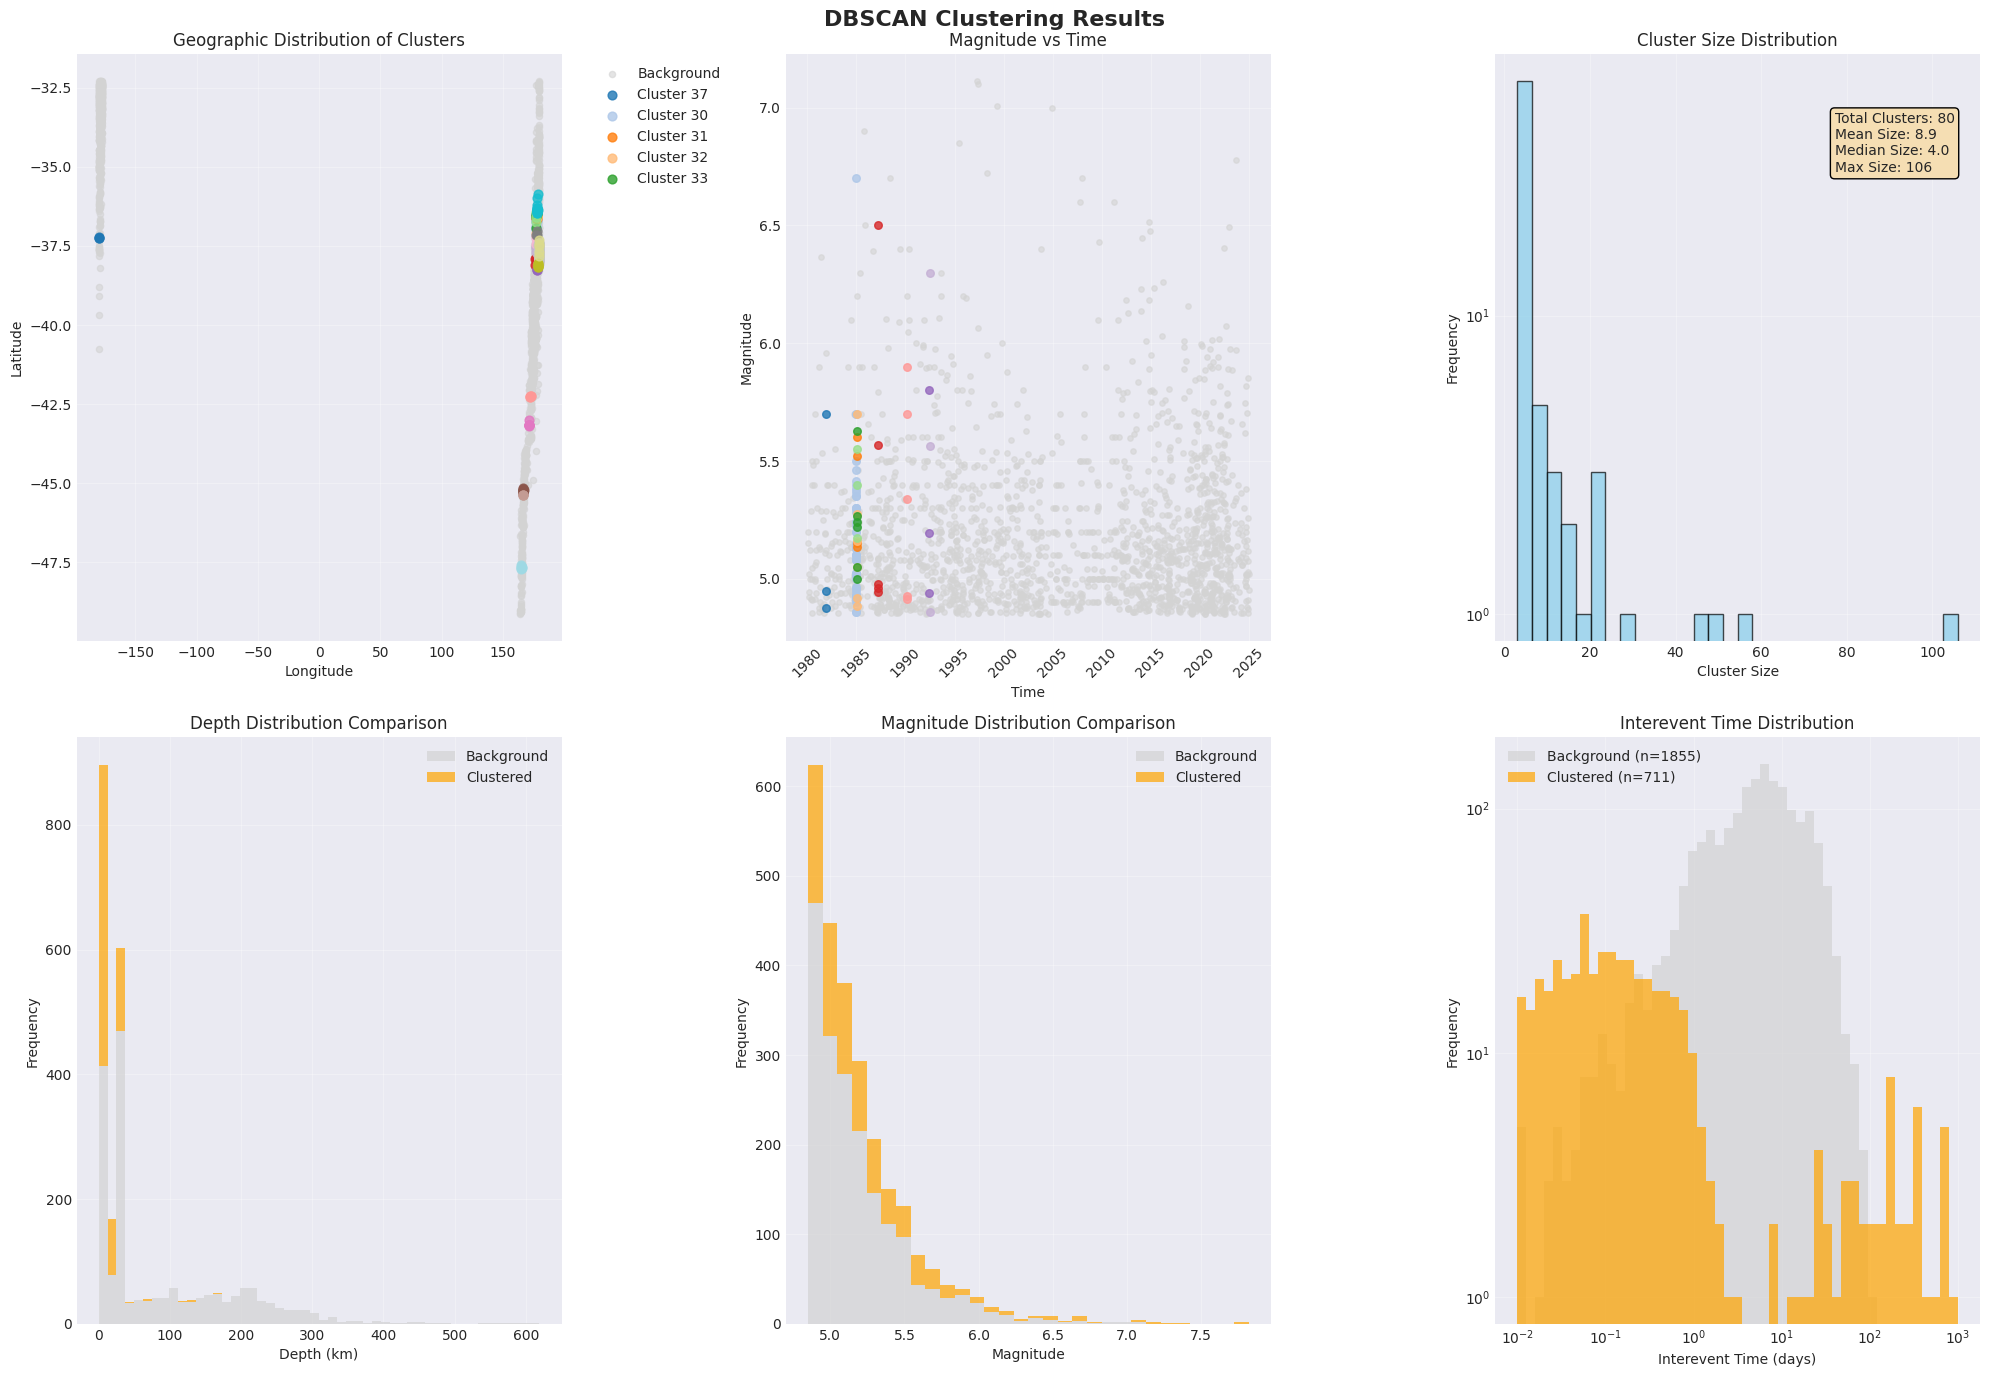

2025-09-14 08:26:10,620 - INFO - Creating statistical analysis plots...


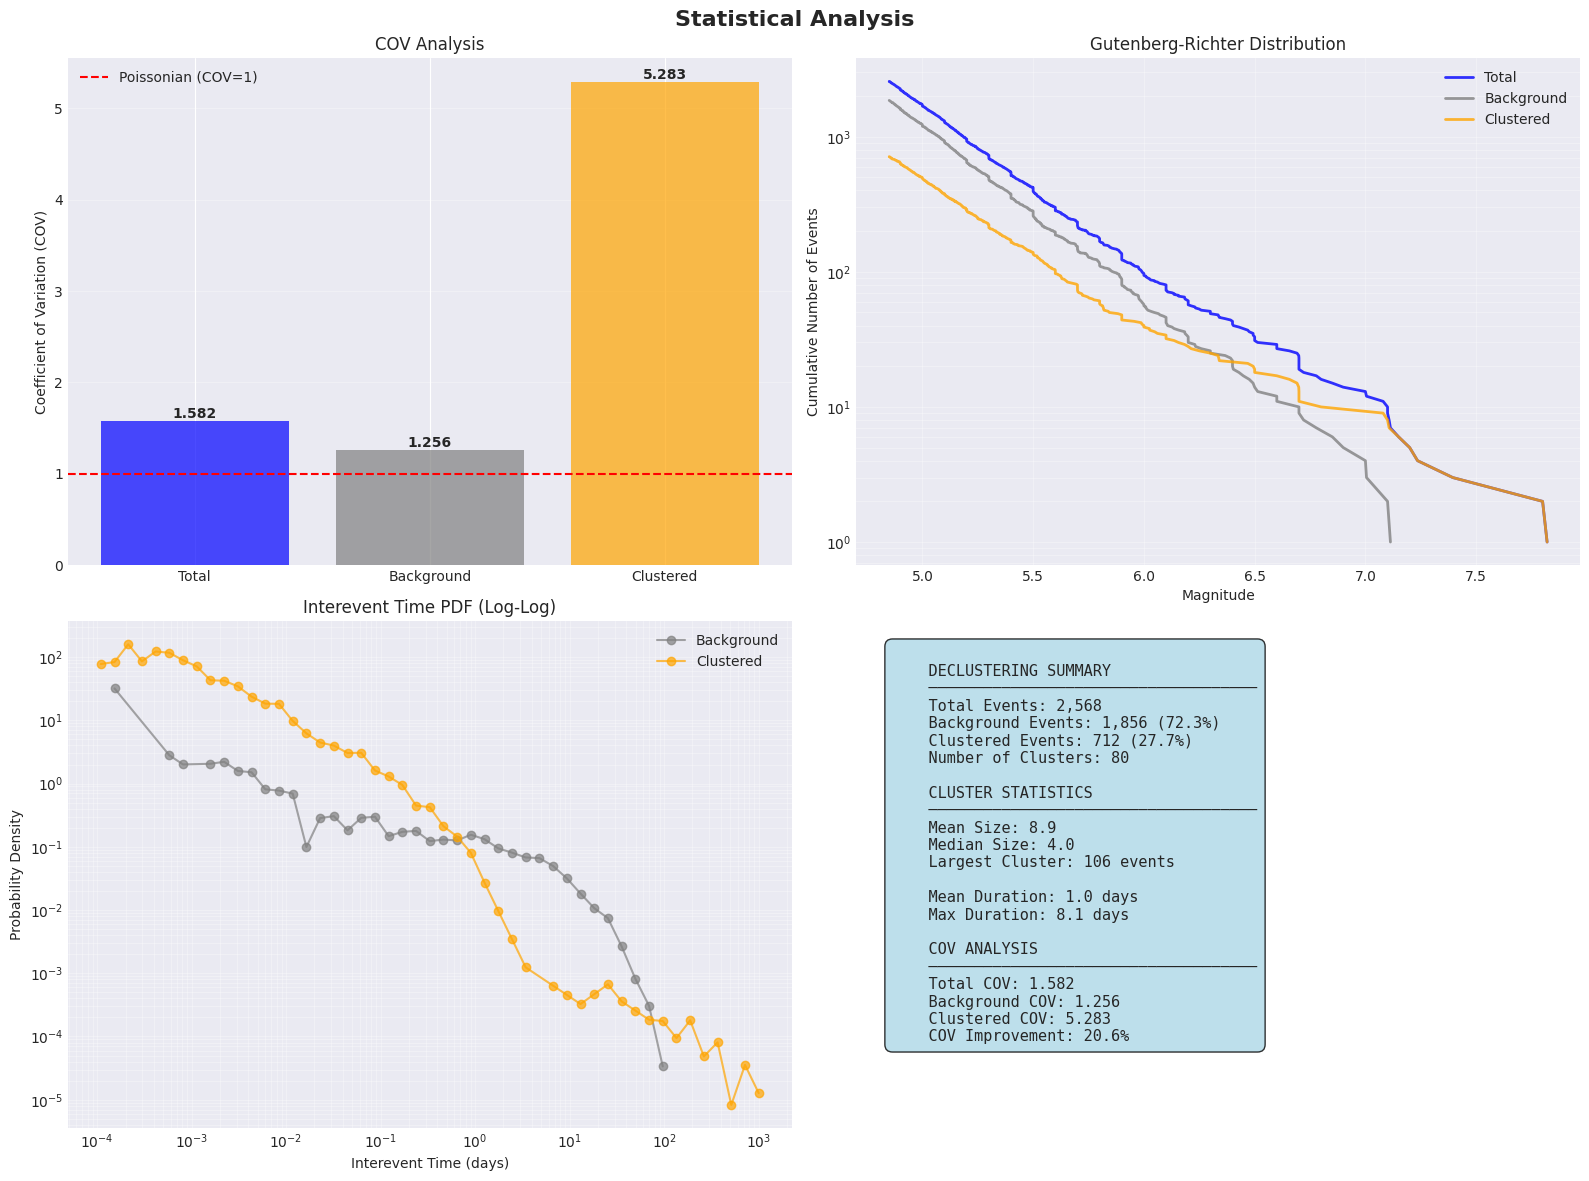

2025-09-14 08:26:13,571 - INFO - Creating detailed plots for top 5 clusters...


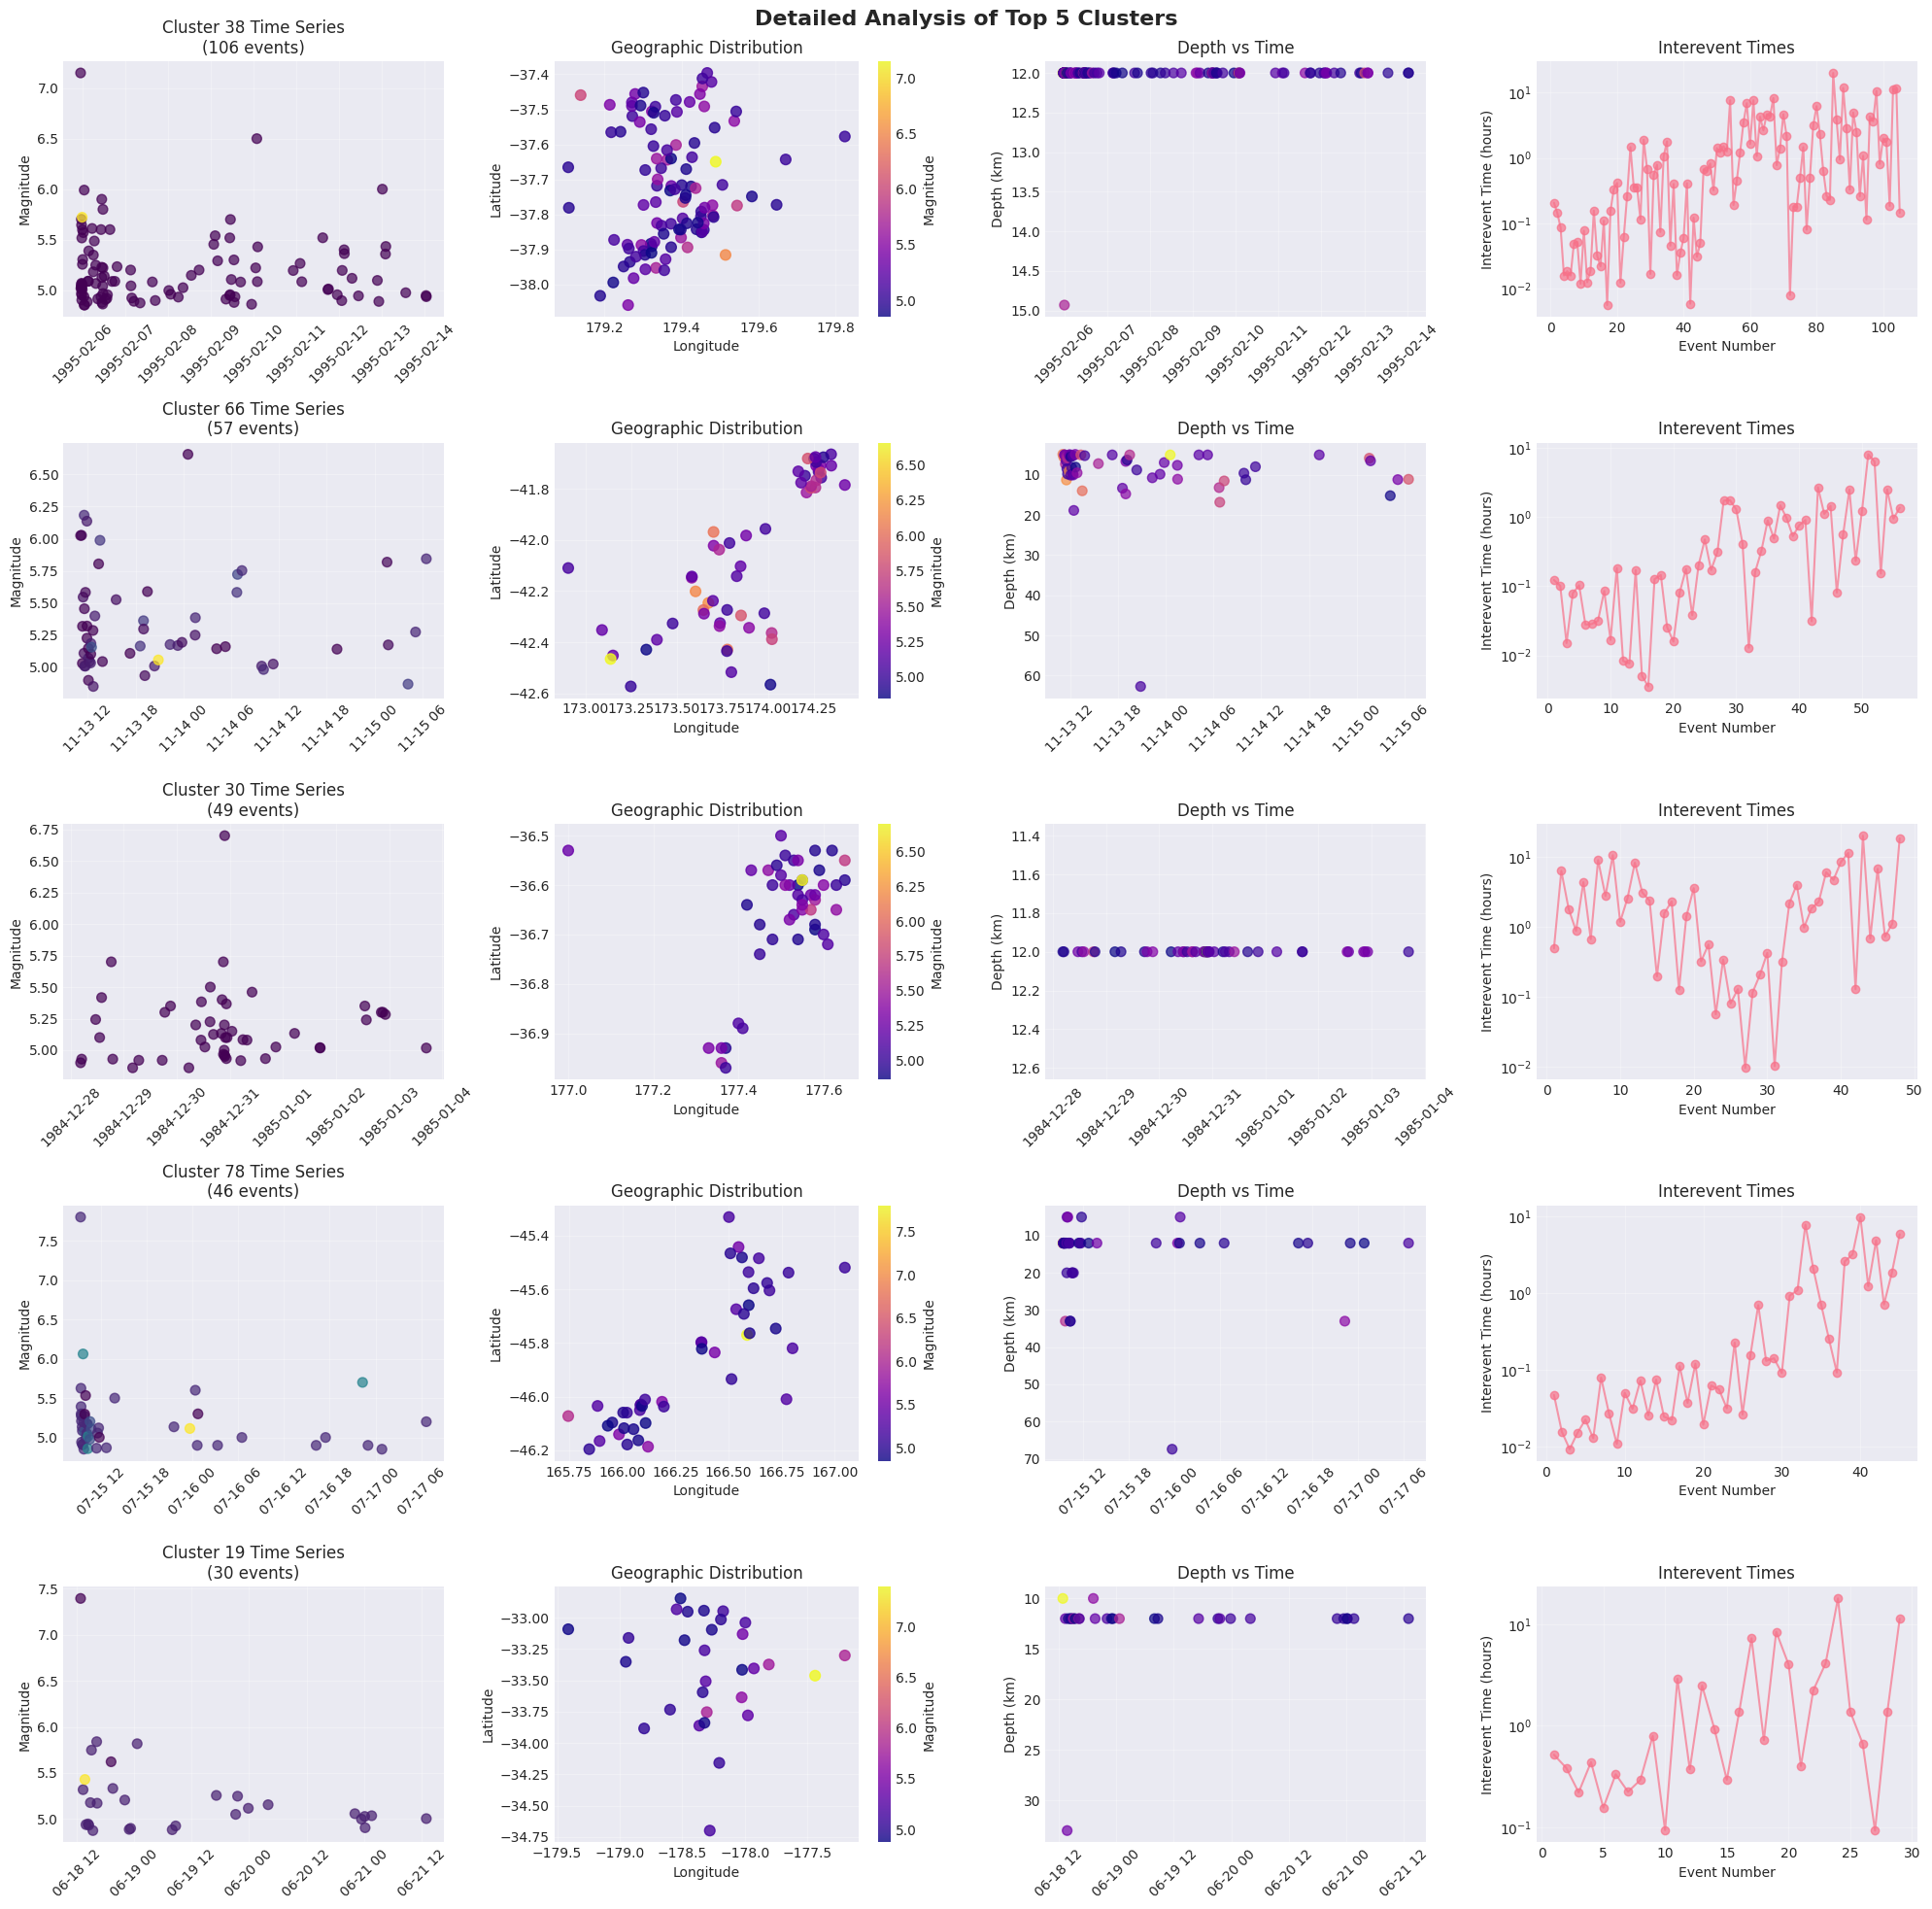

2025-09-14 08:26:21,769 - INFO - Creating parameter sensitivity analysis...


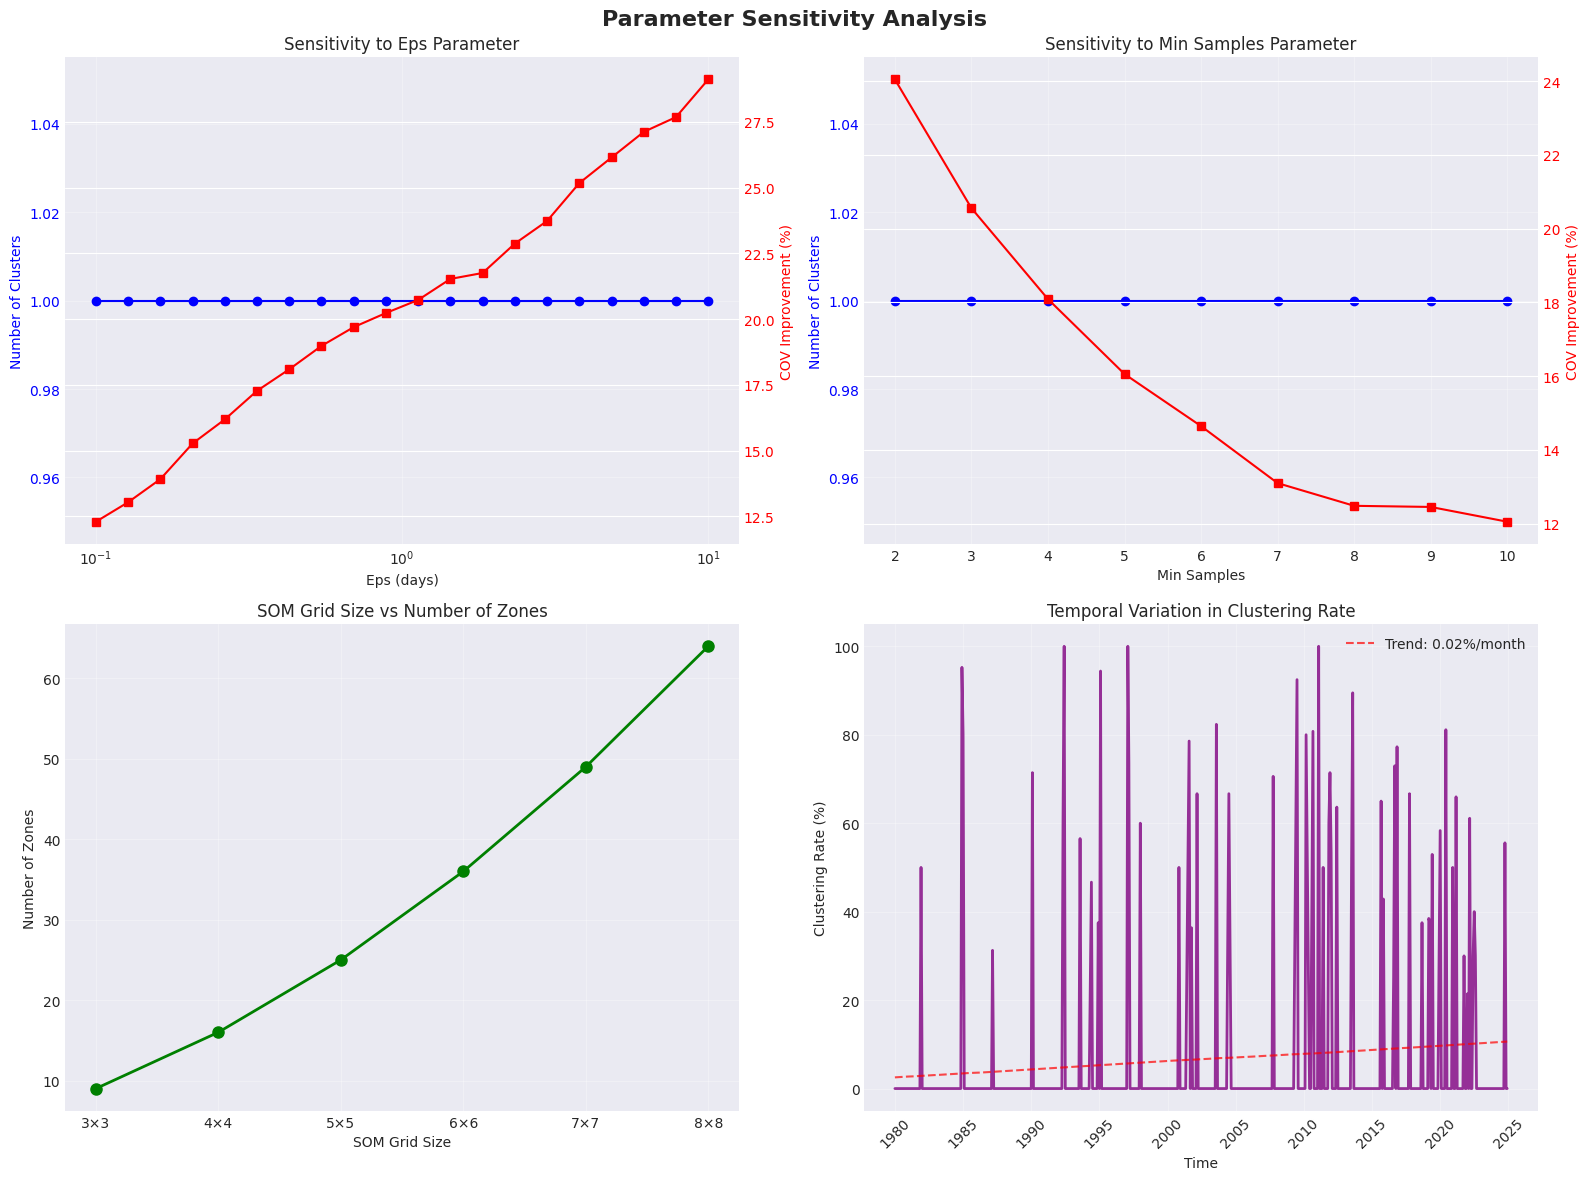

2025-09-14 08:26:24,894 - INFO - Processing completed in 55.91 seconds
2025-09-14 08:26:24,895 - INFO - Results saved to: results
2025-09-14 08:26:24,896 - INFO - ============================================================



✓ Declustering completed successfully!


In [9]:
#!/usr/bin/env python3
"""
som_dbscan_declustering_enhanced.py

Enhanced memory-efficient SOM + temporal-DBSCAN declustering with comprehensive visualization.
- Improved error handling and logging
- Better parameter optimization
- Comprehensive plotting suite
- Statistical analysis and validation
- Progress tracking and performance metrics

Usage:
    pip install numpy pandas matplotlib minisom seaborn scikit-learn tqdm
    python som_dbscan_declustering_enhanced.py /path/to/catalog.csv
"""

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from minisom import MiniSom
from math import radians
from collections import deque
import time
from tqdm import tqdm
import warnings
from datetime import datetime, timedelta
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ---------- constants ----------
RE_KM = 6371.0
COLORS = plt.cm.Set3(np.linspace(0, 1, 12))

# ---------- Enhanced utilities ----------
def setup_logging():
    """Setup basic logging for the pipeline"""
    import logging
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    return logging.getLogger(__name__)

def load_catalog(csv_path):
    """Enhanced catalog loading with better error handling"""
    logger = setup_logging()
    
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Catalog file not found: {csv_path}")
    
    logger.info(f"Loading catalog from {csv_path}")
    df = pd.read_csv(csv_path)
    df.columns = [c.strip() for c in df.columns]
    
    # Check for required columns with flexibility
    required = ['time', 'latitude', 'longitude', 'depth', 'magnitude']
    alt_names = {
        'time': ['datetime', 'origin_time', 'event_time'],
        'latitude': ['lat', 'evt_lat'],
        'longitude': ['lon', 'lng', 'evt_lon'],
        'depth': ['evt_depth', 'event_depth'],
        'magnitude': ['mag', 'evt_mag']
    }
    
    for req_col in required:
        if req_col not in df.columns:
            # Try alternative names
            found = False
            for alt in alt_names.get(req_col, []):
                if alt in df.columns:
                    df[req_col] = df[alt]
                    logger.info(f"Using column '{alt}' for '{req_col}'")
                    found = True
                    break
            if not found:
                raise ValueError(f"Catalog missing required column: {req_col}")
    
    # Enhanced time parsing
    if 'date' in df.columns:
        df['time'] = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce')
    else:
        df['time'] = pd.to_datetime(df['time'], errors='coerce')
    
    # Data validation and cleanup
    initial_len = len(df)
    df = df.dropna(subset=['time', 'latitude', 'longitude', 'depth', 'magnitude'])
    
    # Remove unrealistic values
    df = df[
        (df['latitude'].between(-90, 90)) &
        (df['longitude'].between(-180, 180)) &
        (df['depth'] >= 0) &
        (df['magnitude'] > 0)
    ]
    
    df = df.sort_values('time').reset_index(drop=True)
    
    logger.info(f"Loaded {len(df)}/{initial_len} valid events")
    logger.info(f"Time range: {df['time'].min()} to {df['time'].max()}")
    logger.info(f"Magnitude range: {df['magnitude'].min():.1f} to {df['magnitude'].max():.1f}")
    
    return df

def latlon_depth_to_ecef(lat_deg, lon_deg, depth_km):
    """Convert lat/lon/depth to ECEF coordinates with vectorization"""
    lat = np.radians(lat_deg)
    lon = np.radians(lon_deg)
    r = RE_KM - depth_km
    x = r * np.cos(lat) * np.cos(lon)
    y = r * np.cos(lat) * np.sin(lon)
    z = r * np.sin(lat)
    return np.vstack([x, y, z]).T.astype(np.float32)

# ---------- Enhanced SOM helpers ----------
def quantization_error(som, data, chunk_size=50000):
    """Compute quantization error in chunks for memory efficiency"""
    weights = som.get_weights().reshape(-1, data.shape[1])
    N = data.shape[0]
    tot = 0.0
    
    for i in tqdm(range(0, N, chunk_size), desc="Computing QE", leave=False):
        block = data[i:i+chunk_size]
        diff = block[:, None, :] - weights[None, :, :]
        d = np.linalg.norm(diff, axis=2)
        tot += d.min(axis=1).sum()
    
    return tot / N

def choose_som_grid_and_train(data_xyz, candidate_sizes=[(4,4),(5,5),(6,6),(7,7),(8,8)], 
                             iters=500, sigma=2.0, learning_rate=0.1, random_seed=42):
    """Enhanced SOM training with better parameter selection"""
    logger = setup_logging()
    
    # Standardize data for better SOM training
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_xyz)
    
    results = []
    logger.info("Training SOM candidates...")
    
    for size in tqdm(candidate_sizes, desc="SOM Grid Search"):
        xdim, ydim = size
        som = MiniSom(xdim, ydim, data_scaled.shape[1], 
                      sigma=sigma, learning_rate=learning_rate,
                      neighborhood_function='gaussian', 
                      random_seed=random_seed)
        
        som.pca_weights_init(data_scaled)
        som.train_random(data_scaled, iters, verbose=False)
        
        qe = quantization_error(som, data_scaled)
        
        # Compute topographic error as additional metric
        te = compute_topographic_error(som, data_scaled)
        
        results.append({
            'size': size, 
            'som': som, 
            'scaler': scaler,
            'qe': qe, 
            'te': te,
            'score': qe + 0.1 * te  # Combined score
        })
        
        logger.info(f"  {size}: QE={qe:.4f}, TE={te:.4f}")
    
    # Select best SOM based on combined score
    best = min(results, key=lambda r: r['score'])
    logger.info(f"Selected SOM grid: {best['size']} (QE={best['qe']:.4f}, TE={best['te']:.4f})")
    
    return best['som'], best['scaler'], results

def compute_topographic_error(som, data, chunk_size=10000):
    """Compute topographic error for SOM quality assessment"""
    weights = som.get_weights().reshape(-1, data.shape[1])
    xdim, ydim = som.get_weights().shape[:2]
    
    topographic_errors = 0
    total_samples = 0
    
    for i in range(0, len(data), chunk_size):
        chunk = data[i:i+chunk_size]
        
        # Find distances to all neurons
        distances = np.linalg.norm(chunk[:, None, :] - weights[None, :, :], axis=2)
        
        # Find two best matching units
        sorted_indices = np.argsort(distances, axis=1)
        bmu1_idx = sorted_indices[:, 0]
        bmu2_idx = sorted_indices[:, 1]
        
        # Convert linear indices to 2D coordinates
        bmu1_x, bmu1_y = bmu1_idx // ydim, bmu1_idx % ydim
        bmu2_x, bmu2_y = bmu2_idx // ydim, bmu2_idx % ydim
        
        # Check if BMUs are neighbors (adjacent)
        are_neighbors = (np.abs(bmu1_x - bmu2_x) <= 1) & (np.abs(bmu1_y - bmu2_y) <= 1)
        topographic_errors += np.sum(~are_neighbors)
        total_samples += len(chunk)
    
    return topographic_errors / total_samples

def bmu_assign_chunked(som, scaler, data_xyz, chunk_size=50000):
    """Enhanced BMU assignment with progress tracking"""
    data_scaled = scaler.transform(data_xyz)
    weights = som.get_weights().reshape(-1, data_scaled.shape[1])
    xdim, ydim = som.get_weights().shape[:2]
    N = data_scaled.shape[0]
    winners = np.empty((N, 2), dtype=np.int32)
    
    for i in tqdm(range(0, N, chunk_size), desc="Assigning BMUs"):
        block = data_scaled[i:i+chunk_size]
        diff = block[:, None, :] - weights[None, :, :]
        d = np.linalg.norm(diff, axis=2)
        idx = d.argmin(axis=1)
        x_idx = idx // ydim
        y_idx = idx % ydim
        winners[i:i+block.shape[0], 0] = x_idx
        winners[i:i+block.shape[0], 1] = y_idx
    
    return winners

# ---------- Enhanced 1D DBSCAN ----------
def dbscan_1d_times(times_days, eps, min_samples):
    """Enhanced 1D DBSCAN with better handling of edge cases"""
    n = len(times_days)
    if n == 0:
        return np.array([], dtype=int)
    if n < min_samples:
        return np.full(n, -1, dtype=int)
    
    order = np.argsort(times_days)
    times_sorted = times_days[order]
    
    # Precompute neighborhoods
    L = np.empty(n, dtype=np.int32)
    R = np.empty(n, dtype=np.int32)
    
    j = 0
    for i in range(n):
        if j < i:
            j = i
        while j + 1 < n and times_sorted[j + 1] - times_sorted[i] <= eps:
            j += 1
        R[i] = j
    
    j = 0
    for i in range(n):
        while j < i and times_sorted[i] - times_sorted[j] > eps:
            j += 1
        L[i] = j
    
    neigh_count = (R - L + 1)
    core = neigh_count >= min_samples
    
    labels_sorted = np.full(n, -1, dtype=int)
    cluster_id = 0
    visited = np.zeros(n, dtype=bool)
    
    # Find core points and form clusters
    for i in range(n):
        if visited[i] or not core[i]:
            continue
        
        queue = deque([i])
        visited[i] = True
        labels_sorted[i] = cluster_id
        
        while queue:
            u = queue.popleft()
            for v in range(L[u], R[u] + 1):
                if not visited[v]:
                    visited[v] = True
                    labels_sorted[v] = cluster_id
                    if core[v]:
                        queue.append(v)
        cluster_id += 1
    
    # Assign border points to nearest core point
    for idx_unl in np.where(labels_sorted == -1)[0]:
        for v in range(L[idx_unl], R[idx_unl] + 1):
            if core[v] and labels_sorted[v] != -1:
                labels_sorted[idx_unl] = labels_sorted[v]
                break
    
    # Reorder results back to original order
    labels = np.full(n, -1, dtype=int)
    labels[order] = labels_sorted
    
    return labels

# ---------- Enhanced validation and statistics ----------
def compute_iet_ied(df):
    """Compute interevent times and distances with enhanced statistics"""
    df_sorted = df.sort_values('time').reset_index(drop=True)
    if len(df_sorted) < 2:
        return np.array([]), np.array([])
    
    # Interevent times in days
    time_diffs = df_sorted['time'].diff()
    iet = time_diffs.dt.total_seconds().values[1:] / 86400.0
    
    # Interevent distances using haversine formula
    lat1 = np.radians(df_sorted['latitude'].values[:-1])
    lat2 = np.radians(df_sorted['latitude'].values[1:])
    lon1 = np.radians(df_sorted['longitude'].values[:-1])
    lon2 = np.radians(df_sorted['longitude'].values[1:])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    Rij = RE_KM * c
    
    # Include depth difference
    dz = df_sorted['depth'].values[1:] - df_sorted['depth'].values[:-1]
    ied = np.sqrt(Rij**2 + dz**2)
    
    return iet, ied

def compute_statistics(interevent_times_days):
    """Compute comprehensive statistics for interevent times"""
    if len(interevent_times_days) == 0:
        return {'cov': np.nan, 'mean': np.nan, 'std': np.nan, 'median': np.nan}
    
    mu = np.mean(interevent_times_days)
    sigma = np.std(interevent_times_days, ddof=0)
    
    return {
        'cov': sigma / mu if mu != 0 else np.nan,
        'mean': mu,
        'std': sigma,
        'median': np.median(interevent_times_days),
        'p25': np.percentile(interevent_times_days, 25),
        'p75': np.percentile(interevent_times_days, 75),
        'min': np.min(interevent_times_days),
        'max': np.max(interevent_times_days)
    }

# ---------- Plotting functions ----------
def plot_som_results(som, data_xyz, winners, df, outdir):
    """Create comprehensive SOM visualization plots"""
    logger = setup_logging()
    logger.info("Creating SOM visualization plots...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Self-Organizing Map Analysis', fontsize=16, fontweight='bold')
    
    # 1. U-Matrix (Unified Distance Matrix)
    ax = axes[0, 0]
    weights = som.get_weights()
    u_matrix = np.zeros(weights.shape[:2])
    
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            neighbors = []
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < weights.shape[0] and 0 <= nj < weights.shape[1] and (di != 0 or dj != 0):
                        neighbors.append(weights[ni, nj])
            if neighbors:
                u_matrix[i, j] = np.mean([np.linalg.norm(weights[i, j] - n) for n in neighbors])
    
    im1 = ax.imshow(u_matrix, cmap='coolwarm', interpolation='nearest')
    ax.set_title('U-Matrix (Distance Map)')
    ax.set_xlabel('SOM Y')
    ax.set_ylabel('SOM X')
    plt.colorbar(im1, ax=ax)
    
    # 2. Hit histogram
    ax = axes[0, 1]
    xdim, ydim = som.get_weights().shape[:2]
    hit_map = np.zeros((xdim, ydim))
    for x, y in winners:
        hit_map[x, y] += 1
    
    im2 = ax.imshow(hit_map, cmap='YlOrRd', interpolation='nearest')
    ax.set_title('Hit Histogram')
    ax.set_xlabel('SOM Y')
    ax.set_ylabel('SOM X')
    plt.colorbar(im2, ax=ax)
    
    # Add text annotations for hit counts
    for i in range(xdim):
        for j in range(ydim):
            ax.text(j, i, f'{int(hit_map[i, j])}', ha='center', va='center',
                   color='white' if hit_map[i, j] > hit_map.max()/2 else 'black',
                   fontsize=8, fontweight='bold')
    
    # 3. Magnitude distribution per zone
    ax = axes[0, 2]
    zone_ids = winners[:, 0] * ydim + winners[:, 1]
    unique_zones = np.unique(zone_ids)
    
    mag_means = []
    for zone in unique_zones:
        zone_mask = zone_ids == zone
        mag_means.append(df.loc[zone_mask, 'magnitude'].mean())
    
    mag_matrix = np.full((xdim, ydim), np.nan)
    for i, zone in enumerate(unique_zones):
        x, y = zone // ydim, zone % ydim
        mag_matrix[x, y] = mag_means[i]
    
    im3 = ax.imshow(mag_matrix, cmap='viridis', interpolation='nearest')
    ax.set_title('Mean Magnitude per Zone')
    ax.set_xlabel('SOM Y')
    ax.set_ylabel('SOM X')
    plt.colorbar(im3, ax=ax)
    
    # 4. Temporal distribution
    ax = axes[1, 0]
    df['year'] = df['time'].dt.year
    yearly_counts = df.groupby(['som_zone', 'year']).size().unstack(fill_value=0)
    
    # Plot temporal evolution for top 5 most active zones
    top_zones = hit_map.flatten().argsort()[-5:]
    
    for zone in top_zones:
        if zone in yearly_counts.index:
            ax.plot(yearly_counts.columns, yearly_counts.loc[zone], 
                   marker='o', label=f'Zone {zone}', alpha=0.7)
    
    ax.set_title('Temporal Evolution (Top 5 Zones)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Event Count')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 5. Depth distribution per zone
    ax = axes[1, 1]
    depth_means = []
    for zone in unique_zones:
        zone_mask = zone_ids == zone
        depth_means.append(df.loc[zone_mask, 'depth'].mean())
    
    depth_matrix = np.full((xdim, ydim), np.nan)
    for i, zone in enumerate(unique_zones):
        x, y = zone // ydim, zone % ydim
        depth_matrix[x, y] = depth_means[i]
    
    im4 = ax.imshow(depth_matrix, cmap='plasma', interpolation='nearest')
    ax.set_title('Mean Depth per Zone (km)')
    ax.set_xlabel('SOM Y')
    ax.set_ylabel('SOM X')
    plt.colorbar(im4, ax=ax)
    
    # 6. Zone activity vs magnitude relationship
    ax = axes[1, 2]
    zone_stats = df.groupby('som_zone').agg({
        'magnitude': ['count', 'mean'],
        'depth': 'mean'
    }).round(2)
    
    counts = zone_stats[('magnitude', 'count')].values
    mag_means = zone_stats[('magnitude', 'mean')].values
    
    scatter = ax.scatter(counts, mag_means, c=range(len(counts)), 
                        s=100, alpha=0.7, cmap='tab10')
    ax.set_xlabel('Event Count')
    ax.set_ylabel('Mean Magnitude')
    ax.set_title('Zone Activity vs Mean Magnitude')
    ax.grid(True, alpha=0.3)
    
    # Add trend line
    if len(counts) > 1:
        z = np.polyfit(counts, mag_means, 1)
        p = np.poly1d(z)
        ax.plot(counts, p(counts), "r--", alpha=0.8, 
               label=f'Trend: {z[0]:.3f}x + {z[1]:.2f}')
        ax.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'som_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

def plot_clustering_results(df, outdir):
    """Create comprehensive clustering visualization plots"""
    logger = setup_logging()
    logger.info("Creating clustering visualization plots...")
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    fig.suptitle('DBSCAN Clustering Results', fontsize=16, fontweight='bold')
    
    clustered = df[df['is_aftershock'] == 1]
    background = df[df['is_aftershock'] == 0]
    unique_clusters = clustered['global_cluster'].unique()
    colors = plt.cm.tab20(np.linspace(0, 1, min(len(unique_clusters), 20)))

    # 1. Geographic distribution of clusters
    ax = axes[0, 0]
    ax.scatter(background['longitude'], background['latitude'], 
               c='lightgray', s=20, alpha=0.6, label='Background')
    
    for i, cluster in enumerate(unique_clusters[:20]):
        cluster_events = clustered[clustered['global_cluster'] == cluster]
        ax.scatter(cluster_events['longitude'], cluster_events['latitude'],
                  c=[colors[i]], s=40, alpha=0.8, 
                  label=f'Cluster {cluster}' if i < 5 else '')
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Geographic Distribution of Clusters')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # 2. Magnitude-time plot
    ax = axes[0, 1]
    ax.scatter(background['time'], background['magnitude'], 
               c='lightgray', s=15, alpha=0.6, label='Background')
    
    for i, cluster in enumerate(unique_clusters[:10]):
        cluster_events = clustered[clustered['global_cluster'] == cluster]
        ax.scatter(cluster_events['time'], cluster_events['magnitude'],
                  c=[colors[i]], s=30, alpha=0.8)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Magnitude')
    ax.set_title('Magnitude vs Time')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # 3. Cluster size distribution
    ax = axes[0, 2]
    if not clustered.empty:
        cluster_sizes = clustered.groupby('global_cluster').size()
        ax.hist(cluster_sizes, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax.text(0.7, 0.8, f'Total Clusters: {len(cluster_sizes)}\n'
                         f'Mean Size: {cluster_sizes.mean():.1f}\n'
                         f'Median Size: {cluster_sizes.median():.1f}\n'
                         f'Max Size: {cluster_sizes.max()}',
               transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))
    else:
        ax.text(0.5, 0.5, "No clusters found", ha='center', va='center', transform=ax.transAxes)
    ax.set_xlabel('Cluster Size')
    ax.set_ylabel('Frequency')
    ax.set_title('Cluster Size Distribution')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    
    # 4. Depth distribution comparison
    ax = axes[1, 0]
    ax.hist([background['depth'], clustered['depth']], 
            bins=50, alpha=0.7, label=['Background', 'Clustered'],
            color=['lightgray', 'orange'], stacked=True)
    ax.set_xlabel('Depth (km)')
    ax.set_ylabel('Frequency')
    ax.set_title('Depth Distribution Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 5. Magnitude distribution comparison
    ax = axes[1, 1]
    ax.hist([background['magnitude'], clustered['magnitude']], 
            bins=30, alpha=0.7, label=['Background', 'Clustered'],
            color=['lightgray', 'orange'], stacked=True)
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Frequency')
    ax.set_title('Magnitude Distribution Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 6. Temporal clustering effectiveness
    ax = axes[1, 2]
    iet_bg, _ = compute_iet_ied(background)
    iet_cl, _ = compute_iet_ied(clustered)
    
    if len(iet_bg) > 0 or len(iet_cl) > 0:
        bins = np.logspace(-2, 3, 50)
        ax.hist(iet_bg[iet_bg > 0], bins=bins, alpha=0.7, 
               label=f'Background (n={len(iet_bg)})', color='lightgray')
        ax.hist(iet_cl[iet_cl > 0], bins=bins, alpha=0.7, 
               label=f'Clustered (n={len(iet_cl)})', color='orange')
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.text(0.5, 0.5, "Not enough data for IET plot", ha='center', va='center', transform=ax.transAxes)
    
    ax.set_xlabel('Interevent Time (days)')
    ax.set_ylabel('Frequency')
    ax.set_title('Interevent Time Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'clustering_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

def plot_statistical_analysis(df, outdir):
    """Create statistical analysis plots"""
    logger = setup_logging()
    logger.info("Creating statistical analysis plots...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Statistical Analysis', fontsize=16, fontweight='bold')
    
    # Separate populations
    background = df[df['is_aftershock'] == 0]
    clustered = df[df['is_aftershock'] == 1]
    
    # Compute stats for different populations
    iet_total, _ = compute_iet_ied(df)
    iet_bg, _ = compute_iet_ied(background)
    iet_cl, _ = compute_iet_ied(clustered)
    
    stats_total = compute_statistics(iet_total)
    stats_bg = compute_statistics(iet_bg)
    stats_cl = compute_statistics(iet_cl)
    
    # 1. COV analysis
    ax = axes[0, 0]
    populations = ['Total', 'Background', 'Clustered']
    covs = [stats_total['cov'], stats_bg['cov'], stats_cl['cov']]
    colors_bar = ['blue', 'gray', 'orange']
    
    bars = ax.bar(populations, covs, color=colors_bar, alpha=0.7)
    ax.set_ylabel('Coefficient of Variation (COV)')
    ax.set_title('COV Analysis')
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(1, color='red', linestyle='--', label='Poissonian (COV=1)')
    ax.legend()
    
    for bar, cov in zip(bars, covs):
        height = bar.get_height()
        if not np.isnan(height):
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{cov:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Magnitude frequency distribution (Gutenberg-Richter)
    ax = axes[0, 1]
    mags_sorted = np.sort(df['magnitude'])[::-1]
    cumulative_counts = np.arange(1, len(mags_sorted) + 1)
    
    mags_bg_sorted = np.sort(background['magnitude'])[::-1]
    cumulative_bg = np.arange(1, len(mags_bg_sorted) + 1)
    
    mags_cl_sorted = np.sort(clustered['magnitude'])[::-1]
    cumulative_cl = np.arange(1, len(mags_cl_sorted) + 1)
    
    ax.semilogy(mags_sorted, cumulative_counts, 'b-', linewidth=2, label='Total', alpha=0.8)
    if len(mags_bg_sorted)>0:
        ax.semilogy(mags_bg_sorted, cumulative_bg, 'gray', linewidth=2, label='Background', alpha=0.8)
    if len(mags_cl_sorted)>0:
        ax.semilogy(mags_cl_sorted, cumulative_cl, 'orange', linewidth=2, label='Clustered', alpha=0.8)
    
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Cumulative Number of Events')
    ax.set_title('Gutenberg-Richter Distribution')
    ax.legend()
    ax.grid(True, which='both', alpha=0.3)
    
    # 3. Interevent time distributions (log-log plot)
    ax = axes[1, 0]
    if len(iet_bg) > 0 and len(iet_cl) > 0:
        min_val = min(iet_bg.min() if len(iet_bg) > 0 else 1, iet_cl.min() if len(iet_cl) > 0 else 1, 0.001)
        max_val = max(iet_bg.max() if len(iet_bg) > 0 else 1, iet_cl.max() if len(iet_cl) > 0 else 1)
        bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)
        
        hist_bg, _ = np.histogram(iet_bg[iet_bg > 0], bins=bins)
        hist_cl, _ = np.histogram(iet_cl[iet_cl > 0], bins=bins)
        
        bin_centers = (bins[1:] + bins[:-1]) / 2
        
        pdf_bg = hist_bg / (np.sum(hist_bg) * np.diff(bins)) if np.sum(hist_bg) > 0 else np.zeros_like(hist_bg)
        pdf_cl = hist_cl / (np.sum(hist_cl) * np.diff(bins)) if np.sum(hist_cl) > 0 else np.zeros_like(hist_cl)
        
        ax.loglog(bin_centers[pdf_bg > 0], pdf_bg[pdf_bg > 0], 'o-', color='gray', label='Background', alpha=0.7)
        ax.loglog(bin_centers[pdf_cl > 0], pdf_cl[pdf_cl > 0], 'o-', color='orange', label='Clustered', alpha=0.7)
    
    ax.set_xlabel('Interevent Time (days)')
    ax.set_ylabel('Probability Density')
    ax.set_title('Interevent Time PDF (Log-Log)')
    ax.legend()
    ax.grid(True, which='both', alpha=0.3)
    
    # 4. Cluster characteristics summary
    ax = axes[1, 1]
    ax.axis('off')
    if len(clustered) > 0:
        cluster_stats = clustered.groupby('global_cluster').agg(
            Size=('magnitude', 'count'),
            Mean_Mag=('magnitude', 'mean'),
            Max_Mag=('magnitude', 'max'),
            Duration_days=('time', lambda x: (x.max() - x.min()).total_seconds() / 86400),
            Mean_Depth=('depth', 'mean')
        ).round(2)
    else:
        cluster_stats = pd.DataFrame()
    
    declustering_efficiency = len(clustered) / len(df) * 100 if len(df) > 0 else 0
    
    summary_text = f"""
    DECLUSTERING SUMMARY
    ────────────────────────────────────
    Total Events: {len(df):,}
    Background Events: {len(background):,} ({100-declustering_efficiency:.1f}%)
    Clustered Events: {len(clustered):,} ({declustering_efficiency:.1f}%)
    Number of Clusters: {len(cluster_stats)}
    
    CLUSTER STATISTICS
    ────────────────────────────────────"""
    
    if not cluster_stats.empty:
        summary_text += f"""
    Mean Size: {cluster_stats['Size'].mean():.1f}
    Median Size: {cluster_stats['Size'].median():.1f}
    Largest Cluster: {cluster_stats['Size'].max():.0f} events
    
    Mean Duration: {cluster_stats['Duration_days'].mean():.1f} days
    Max Duration: {cluster_stats['Duration_days'].max():.1f} days"""
    else:
        summary_text += "\n    No clusters found"
    
    summary_text += f"""
    
    COV ANALYSIS
    ────────────────────────────────────
    Total COV: {stats_total['cov']:.3f}
    Background COV: {stats_bg['cov']:.3f}
    Clustered COV: {stats_cl['cov']:.3f}"""
    
    if not np.isnan(stats_bg['cov']) and not np.isnan(stats_total['cov']) and stats_total['cov'] != 0:
        improvement = (1 - stats_bg['cov'] / stats_total['cov']) * 100
        summary_text += f"\n    COV Improvement: {improvement:.1f}%"
    
    ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=11,
           verticalalignment='top', fontfamily='monospace',
           bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'statistical_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

def plot_cluster_details(df, outdir, top_n=5):
    """Plot detailed analysis of top clusters"""
    logger = setup_logging()
    logger.info(f"Creating detailed plots for top {top_n} clusters...")
    
    clustered = df[df['is_aftershock'] == 1]
    
    if len(clustered) == 0:
        logger.warning("No clusters found - skipping cluster detail plots")
        return
    
    cluster_sizes = clustered.groupby('global_cluster').size().sort_values(ascending=False)
    top_clusters = cluster_sizes.head(top_n).index
    
    fig, axes = plt.subplots(top_n, 4, figsize=(20, 4*top_n), squeeze=False)
    fig.suptitle(f'Detailed Analysis of Top {min(top_n, len(top_clusters))} Clusters', fontsize=16, fontweight='bold')
    
    for i, cluster_id in enumerate(top_clusters):
        cluster_events = clustered[clustered['global_cluster'] == cluster_id].sort_values('time')
        
        # Time series
        ax = axes[i, 0]
        ax.scatter(cluster_events['time'], cluster_events['magnitude'], 
                  c=cluster_events['depth'], cmap='viridis', s=50, alpha=0.7)
        ax.set_ylabel('Magnitude')
        ax.set_title(f'Cluster {cluster_id} Time Series\n({len(cluster_events)} events)')
        ax.grid(True, alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        
        # Geographic plot
        ax = axes[i, 1]
        scatter = ax.scatter(cluster_events['longitude'], cluster_events['latitude'], 
                           c=cluster_events['magnitude'], cmap='plasma', s=60, alpha=0.8)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('Geographic Distribution')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Magnitude')
        
        # Depth profile
        ax = axes[i, 2]
        ax.scatter(cluster_events['time'], cluster_events['depth'], 
                  c=cluster_events['magnitude'], cmap='plasma', s=50, alpha=0.7)
        ax.set_ylabel('Depth (km)')
        ax.set_title('Depth vs Time')
        ax.grid(True, alpha=0.3)
        ax.invert_yaxis()
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        
        # Interevent times
        ax = axes[i, 3]
        if len(cluster_events) > 1:
            time_diffs = cluster_events['time'].diff().dt.total_seconds().values[1:] / 3600  # hours
            ax.semilogy(range(1, len(time_diffs) + 1), time_diffs, 'o-', alpha=0.7)
            ax.set_xlabel('Event Number')
            ax.set_ylabel('Interevent Time (hours)')
            ax.set_title('Interevent Times')
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Single Event\nCluster', ha='center', va='center',
                   transform=ax.transAxes, fontsize=12)
            ax.set_title('Interevent Times')
    
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'cluster_details.png'), dpi=300, bbox_inches='tight')
    plt.show()

def plot_parameter_sensitivity(df, outdir):
    """Plot parameter sensitivity analysis"""
    logger = setup_logging()
    logger.info("Creating parameter sensitivity analysis...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Parameter Sensitivity Analysis', fontsize=16, fontweight='bold')
    
    # Test different eps values
    ax = axes[0, 0]
    eps_values = np.logspace(-1, 1, 20)
    n_clusters_eps = []
    cov_improvement_eps = []
    
    iet_total, _ = compute_iet_ied(df)
    cov_total = compute_statistics(iet_total)['cov']

    for eps in tqdm(eps_values, desc="Testing Eps", leave=False):
        temp_clusters = np.full(len(df), -1, dtype=np.int64)
        for zone in df['som_zone'].unique():
            zone_mask = df['som_zone'] == zone
            zone_times = df.loc[zone_mask, 'time'].values
            if len(zone_times) < 3: continue
            t0 = zone_times.min()
            times_days = (zone_times - t0).astype('timedelta64[s]').astype(np.float64) / 86400.0
            labels = dbscan_1d_times(times_days, eps, 3)
            temp_clusters[df.index[zone_mask][labels != -1]] = 1
        
        n_clusters_eps.append(len(np.unique(temp_clusters[temp_clusters != -1])))
        
        clustered_mask = temp_clusters != -1
        if np.sum(~clustered_mask) > 1:
            iet_bg, _ = compute_iet_ied(df[~clustered_mask])
            cov_bg = compute_statistics(iet_bg)['cov']
            improvement = (1 - cov_bg / cov_total) * 100 if not np.isnan(cov_total) and cov_total != 0 and not np.isnan(cov_bg) else 0
            cov_improvement_eps.append(improvement)
        else:
            cov_improvement_eps.append(0)
    
    ax.semilogx(eps_values, n_clusters_eps, 'b-o', label='Number of Clusters')
    ax.set_xlabel('Eps (days)')
    ax.set_ylabel('Number of Clusters', color='b')
    ax.tick_params(axis='y', labelcolor='b')
    ax.grid(True, alpha=0.3)
    
    ax2 = ax.twinx()
    ax2.semilogx(eps_values, cov_improvement_eps, 'r-s', label='COV Improvement')
    ax2.set_ylabel('COV Improvement (%)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax.set_title('Sensitivity to Eps Parameter')
    
    # Test different min_samples values
    ax = axes[0, 1]
    min_samples_values = range(2, 11)
    n_clusters_ms = []
    cov_improvement_ms = []
    
    for min_samp in tqdm(min_samples_values, desc="Testing MinSamples", leave=False):
        temp_clusters = np.full(len(df), -1, dtype=np.int64)
        for zone in df['som_zone'].unique():
            zone_mask = df['som_zone'] == zone
            zone_times = df.loc[zone_mask, 'time'].values
            if len(zone_times) < min_samp: continue
            t0 = zone_times.min()
            times_days = (zone_times - t0).astype('timedelta64[s]').astype(np.float64) / 86400.0
            labels = dbscan_1d_times(times_days, 1.0, min_samp)
            temp_clusters[df.index[zone_mask][labels != -1]] = 1

        n_clusters_ms.append(len(np.unique(temp_clusters[temp_clusters != -1])))
        
        clustered_mask = temp_clusters != -1
        if np.sum(~clustered_mask) > 1:
            iet_bg, _ = compute_iet_ied(df[~clustered_mask])
            cov_bg = compute_statistics(iet_bg)['cov']
            improvement = (1 - cov_bg / cov_total) * 100 if not np.isnan(cov_total) and cov_total != 0 and not np.isnan(cov_bg) else 0
            cov_improvement_ms.append(improvement)
        else:
            cov_improvement_ms.append(0)
    
    ax.plot(min_samples_values, n_clusters_ms, 'b-o', label='Number of Clusters')
    ax.set_xlabel('Min Samples')
    ax.set_ylabel('Number of Clusters', color='b')
    ax.tick_params(axis='y', labelcolor='b')
    ax.grid(True, alpha=0.3)
    
    ax2 = ax.twinx()
    ax2.plot(min_samples_values, cov_improvement_ms, 'r-s', label='COV Improvement')
    ax2.set_ylabel('COV Improvement (%)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax.set_title('Sensitivity to Min Samples Parameter')
    
    # SOM grid size comparison
    ax = axes[1, 0]
    som_sizes = [(3,3), (4,4), (5,5), (6,6), (7,7), (8,8)]
    som_labels = [f'{x}×{y}' for x, y in som_sizes]
    n_zones = [x*y for x, y in som_sizes]
    ax.plot(som_labels, n_zones, 'g-o', linewidth=2, markersize=8)
    ax.set_xlabel('SOM Grid Size')
    ax.set_ylabel('Number of Zones')
    ax.set_title('SOM Grid Size vs Number of Zones')
    ax.grid(True, alpha=0.3)
    
    # Performance metrics over time
    ax = axes[1, 1]
    df['year_month'] = df['time'].dt.to_period('M')
    monthly_stats = df.groupby('year_month').agg(
        total_events=('is_aftershock', 'count'),
        clustered_events=('is_aftershock', 'sum')
    )
    monthly_stats['clustering_rate'] = monthly_stats['clustered_events'] / monthly_stats['total_events'] * 100
    
    ax.plot(monthly_stats.index.to_timestamp(), monthly_stats['clustering_rate'], 'purple', linewidth=2, alpha=0.8)
    ax.set_xlabel('Time')
    ax.set_ylabel('Clustering Rate (%)')
    ax.set_title('Temporal Variation in Clustering Rate')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    if len(monthly_stats) > 2:
        x_numeric = np.arange(len(monthly_stats))
        z = np.polyfit(x_numeric, monthly_stats['clustering_rate'].fillna(0), 1)
        trend = np.poly1d(z)(x_numeric)
        ax.plot(monthly_stats.index.to_timestamp(), trend, 'r--', alpha=0.7, label=f'Trend: {z[0]:.2f}%/month')
        ax.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'parameter_sensitivity.png'), dpi=300, bbox_inches='tight')
    plt.show()

# ---------- Enhanced main pipeline ----------
def run_pipeline(csv_path, outdir='results', som_candidates=[(4,4),(5,5),(6,6),(7,7),(8,8)],
                 som_iters=500, som_sigma=2.0, som_lr=0.1, eps_days=1.0, min_samples=3,
                 bmu_chunk=50000, create_plots=True):
    """Enhanced pipeline with comprehensive analysis and visualization"""
    
    start_time = time.time()
    logger = setup_logging()
    
    os.makedirs(outdir, exist_ok=True)
    
    logger.info("=" * 60)
    logger.info("ENHANCED SOM + DBSCAN DECLUSTERING PIPELINE")
    logger.info("=" * 60)
    
    logger.info("Step 1: Loading and validating catalog...")
    df = load_catalog(csv_path)
    
    logger.info("Step 2: Converting coordinates to ECEF...")
    coords_ecef = latlon_depth_to_ecef(df['latitude'].values, df['longitude'].values, df['depth'].values)
    
    logger.info("Step 3: Training Self-Organizing Map...")
    som, scaler, _ = choose_som_grid_and_train(
        coords_ecef, candidate_sizes=som_candidates,
        iters=som_iters, sigma=som_sigma, learning_rate=som_lr
    )
    
    logger.info("Step 4: Assigning Best Matching Units...")
    winners = bmu_assign_chunked(som, scaler, coords_ecef, chunk_size=bmu_chunk)
    
    xdim, ydim = som.get_weights().shape[:2]
    zone_ids = winners[:, 0] * ydim + winners[:, 1]
    df['som_zone'] = zone_ids
    
    logger.info("Step 5: Performing temporal DBSCAN clustering...")
    global_cluster_ids = np.full(len(df), -1, dtype=np.int64)
    
    unique_zones = np.unique(zone_ids)
    for zone in tqdm(unique_zones, desc="Processing SOM zones"):
        idxs = np.flatnonzero(zone_ids == zone)
        if len(idxs) < min_samples:
            continue
            
        times = df['time'].iloc[idxs].values
        t0 = times.min()
        times_days = (times - t0).astype('timedelta64[s]').astype(np.float64) / 86400.0
        
        labels_zone = dbscan_1d_times(times_days, eps=eps_days, min_samples=min_samples)
        
        # Create unique global cluster IDs
        max_local_cluster = labels_zone.max()
        if max_local_cluster > -1:
            offset = global_cluster_ids.max() + 1
            unique_labels = np.unique(labels_zone[labels_zone != -1])
            mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels, start=offset)}
            
            for i, idx in enumerate(idxs):
                if labels_zone[i] != -1:
                    global_cluster_ids[idx] = mapping[labels_zone[i]]
    
    df['global_cluster'] = global_cluster_ids
    df['is_aftershock'] = (df['global_cluster'] != -1).astype(int)
    
    logger.info("Step 6: Saving results...")
    out_csv = os.path.join(outdir, 'catalog_declustered.csv')
    df.to_csv(out_csv, index=False)
    
    logger.info("Step 7: Computing statistics...")
    background = df[df['is_aftershock'] == 0]
    clustered = df[df['is_aftershock'] == 1]
    iet_total, _ = compute_iet_ied(df)
    iet_bg, _ = compute_iet_ied(background)
    stats_total = compute_statistics(iet_total)
    stats_bg = compute_statistics(iet_bg)
    n_clusters = len(np.unique(global_cluster_ids[global_cluster_ids != -1]))
    
    logger.info("=" * 60)
    logger.info("DECLUSTERING RESULTS SUMMARY")
    logger.info("=" * 60)
    logger.info(f"Total events: {len(df):,}")
    logger.info(f"Background events: {len(background):,} ({len(background)/len(df)*100:.1f}%)")
    logger.info(f"Clustered events: {len(clustered):,} ({len(clustered)/len(df)*100:.1f}%)")
    logger.info(f"Number of clusters: {n_clusters:,}")
    logger.info(f"COV (total): {stats_total['cov']:.4f}")
    logger.info(f"COV (background): {stats_bg['cov']:.4f}")
    
    if not np.isnan(stats_bg['cov']) and not np.isnan(stats_total['cov']) and stats_total['cov'] > 0:
        improvement = (1 - stats_bg['cov'] / stats_total['cov']) * 100
        logger.info(f"COV improvement: {improvement:.1f}%")
    
    if create_plots:
        logger.info("Step 8: Creating visualization plots...")
        for plot_func in [plot_som_results, plot_clustering_results, plot_statistical_analysis, plot_cluster_details, plot_parameter_sensitivity]:
            try:
                if plot_func == plot_som_results:
                    plot_func(som, coords_ecef, winners, df, outdir)
                elif plot_func == plot_cluster_details:
                    plot_func(df, outdir, top_n=min(5, n_clusters))
                else:
                    plot_func(df, outdir)
            except Exception as e:
                logger.error(f"Failed to create {plot_func.__name__} plots: {e}", exc_info=True)

    report_path = os.path.join(outdir, 'declustering_report.txt')
    with open(report_path, 'w') as f:
        f.write("ENHANCED SOM + DBSCAN DECLUSTERING REPORT\n" + "="*50 + "\n\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Input file: {csv_path}\n")
        f.write(f"Processing time: {time.time() - start_time:.2f} seconds\n\n")
        f.write("PARAMETERS USED:\n" + "-"*20 + "\n")
        f.write(f"SOM candidates: {som_candidates}\nSelected SOM grid: {som.get_weights().shape[:2]}\n")
        f.write(f"SOM iterations: {som_iters}\nSOM sigma: {som_sigma}\nSOM learning rate: {som_lr}\n")
        f.write(f"DBSCAN eps (days): {eps_days}\nDBSCAN min_samples: {min_samples}\n\n")
        f.write("RESULTS SUMMARY:\n" + "-"*20 + "\n")
        f.write(f"Total events: {len(df):,}\n")
        f.write(f"Background events: {len(background):,} ({len(background)/len(df)*100:.1f}%)\n")
        f.write(f"Clustered events: {len(clustered):,} ({len(clustered)/len(df)*100:.1f}%)\n")
        f.write(f"Number of clusters: {n_clusters:,}\n")
        f.write(f"COV (total): {stats_total['cov']:.4f}\nCOV (background): {stats_bg['cov']:.4f}\n")
        if not clustered.empty:
            cluster_sizes = clustered.groupby('global_cluster').size()
            f.write(f"Mean cluster size: {cluster_sizes.mean():.1f}\n")
            f.write(f"Median cluster size: {cluster_sizes.median():.1f}\n")
            f.write(f"Largest cluster: {cluster_sizes.max()} events\n")

    logger.info(f"Processing completed in {time.time() - start_time:.2f} seconds")
    logger.info(f"Results saved to: {outdir}")
    logger.info("=" * 60)
    
    return df, som, scaler

# ---------- Entry point ----------
if __name__ == "__main__":
    if len(sys.argv) < 2 or any(arg in ['-h', '--help'] for arg in sys.argv):
        print("Usage: python som_dbscan_declustering_enhanced.py /path/to/catalog.csv [options]")
        print("\nOptional arguments:")
        print("  --outdir <path>     Output directory (default: results)")
        print("  --eps <days>        DBSCAN epsilon in days (default: 1.0)")
        print("  --min_samples <num> DBSCAN min_samples (default: 3)")
        print("  --som_iters <num>   SOM training iterations (default: 500)")
        print("  --no_plots          Skip creating visualization plots")
        sys.exit(1)
    
    # More robust argument parsing to handle environment-specific args
    args = sys.argv[1:]
    kwargs = {}
    csv_path = "Modified_data.csv"

    # Find the CSV path first (positional argument)
    for arg in args:
        if not arg.startswith('-'):
            csv_path = arg
            break
    
    if not csv_path:
        print("Error: Could not find the path to the catalog CSV file.")
        print("Usage: python som_dbscan_declustering_enhanced.py /path/to/catalog.csv [options]")
        sys.exit(1)

    # Parse optional arguments
    try:
        if '--outdir' in args:
            kwargs['outdir'] = args[args.index('--outdir') + 1]
        if '--eps' in args:
            kwargs['eps_days'] = float(args[args.index('--eps') + 1])
        if '--min_samples' in args:
            kwargs['min_samples'] = int(args[args.index('--min_samples') + 1])
        if '--som_iters' in args:
            kwargs['som_iters'] = int(args[args.index('--som_iters') + 1])
        if '--no_plots' in args:
            kwargs['create_plots'] = False
    except (IndexError, ValueError) as e:
        print(f"Error parsing arguments: {e}")
        sys.exit(1)
        
    try:
        run_pipeline(csv_path=csv_path, **kwargs)
        print(f"\n✓ Declustering completed successfully!")
        
    except Exception as e:
        print(f"\n✗ Error during processing: {e}")
        import traceback
        traceback.print_exc()
        sys.exit(1)

